In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from math import cos, asin, sqrt
import matplotlib.pyplot as plt
import numpy as np
import pickle
import math
import xarray as xr
import netCDF4 as nc
from matplotlib import ticker, cm
from matplotlib import animation, rc
import matplotlib.tri as tri
import sys
#import metpy.calc as mpcalc
#from metpy.cbook import get_test_data
#from metpy.interpolate import cross_section
import scipy.ndimage as ndimage
from mpl_toolkits.axes_grid1 import make_axes_locatable
sys.setrecursionlimit(9000)
import scipy.ndimage
import statistics
import scipy.io
import h5py
from scipy.interpolate import griddata

In [2]:
# Change this part
sYear  = 2008
sMonth = 10
sDay   = 1
sHour  = 0
eYear  = 2008
eMonth = 10
eDay   = 7
eHour  = 0
# Set the location of the column
Center_lon = 5  # 417
Center_lat = -11.0 
Center_lon0 = 5
Center_lat0 = -11.0 

#Center_lon = 102  # 1194
#Center_lat = -30.0 
#Center_lon0 = 102
#Center_lat0 = -30.0  

#Center_lon = 272 #3426
#Center_lat = -14.0 
#Center_lon0 = 272
#Center_lat0 = -14.0  

In [3]:
UPsedi15_PATH = '/media/liran/PLR5/UPsedi/fixed15/'
UPhysedi15 = xr.open_mfdataset(UPsedi15_PATH+'HPhypersedi_sigmag_long_fixed15_L125_ERA5_2008_F-MMF1_frontera_ne16pg2_r05_oQU240_CRM1_64_x_120z200m.5s_crm_nx_rad_16_np_768_nlev_125.frontera.cam.h0.*.nc')
UPsedi20_PATH = '/media/liran/PLR5/UPsedi/fixed20/'
UPhysedi20 = xr.open_mfdataset(UPsedi20_PATH+'HPhypersedi_sigmag_long_fixed20_L125_ERA5_2008_F-MMF1_frontera_ne16pg2_r05_oQU240_CRM1_64_x_120z200m.5s_crm_nx_rad_16_np_768_nlev_125.frontera.cam.h0.*.nc')
UPhy_PATH = '/media/liran/Elements/Frontera_Cases/Peter_smooth_momentum/Ensemble/2008/'
UPhy2008 = xr.open_mfdataset(UPhy_PATH+'Multi-CRM_UPCTRL_hpv_ERA5_2008_F-MMF1_frontera_ne16pg2_r05_oQU240_CRM1_64_x_125z200m.2s_crm_nx_rad_16_np_768_nlev_125.frontera.cam.h0.2008-10-*.nc')

In [4]:
UP_Case = 'Multi-CRM_UPCTRL_v3_ERA5_2008_F-MMF1_frontera_ne16pg2_r05_oQU240_CRM1_64_64x_125z200m.0.5s_crm_nx_rad_16_np_2048_nlev_125.frontera'
UP_PATH = '/media/liran/Elements/Frontera_Cases/ERA5_Ensemble_UP/Multi-CRM_UPCTRL_v3_ERA5_2008_F-MMF1_frontera_ne16pg2_r05_oQU240_CRM1_64_64x_125z200m.0.5s_crm_nx_rad_16_np_2048_nlev_125.frontera/'
UP2008 = xr.open_mfdataset(UP_PATH+UP_Case+'.cam.h0.2008-10-*.nc')
SP_Case = 'Multi-CRM_SPCTRLv3_ERA5_2008_F-MMF1_frontera_ne16pg2_r05_oQU240_CRM1_32_32x_125z1200m.5s_crm_nx_rad_16_np_2048_nlev_125.frontera'
SP_PATH = '/media/liran/Elements/Frontera_Cases/ERA5_Ensemble_SP/Multi-CRM_SPCTRLv3_ERA5_2008_F-MMF1_frontera_ne16pg2_r05_oQU240_CRM1_32_32x_125z1200m.5s_crm_nx_rad_16_np_2048_nlev_125.frontera/'
SP2008 = xr.open_mfdataset(SP_PATH+SP_Case+'.cam.h0.2008-10-*.nc')

In [5]:
lon = SP2008.lon.isel(time=0).values
lat = SP2008.lat.isel(time=0).values
Z3 = SP2008.Z3.isel(time=0).values

In [6]:
# Function calculate the distance between two points
def distance2(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295
    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p)*cos(lat2*p) * (1-cos((lon2-lon1)*p)) / 2
    return 12742 * asin(sqrt(a))

In [7]:
def find_indices(lst, condition):
    return [i for i, elem in enumerate(lst) if condition(elem)]

In [8]:
# Function calculate the distance between two points
def distancef(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295
    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p)*cos(lat2*p) * (1-cos((lon2-lon1)*p)) / 2
    return 12742 * asin(sqrt(a))

In [9]:
# Function calculate the distance between two points
def lonlat_in(lat, lon, lat1, lon1, lat2, lon2):
    flag = 0
    if lon >lon1:
        if lon <lon2:
            if lat >lat1:
                if lat <lat2:
                    flag = 1
    return flag

In [78]:
# Function calculate the distance between two points
def potential_temperature(Temperature_K,Pressure_Pa):
    kapa = 0.286
    P0 = 100000
    return Temperature_K*(P0/Pressure_Pa)**kapa

In [10]:
# UP ==============================================================
T_UP = UP2008.T.values # T vertical diffusion K/s
SPWWUP = UP2008.SPWW.values
CLOUD_UP  = UP2008.CLOUD.values
CLDLIQ_UP  = UP2008.CLDLIQ.values
Q_UP  = UP2008.Q.values
TMQ_UP  = UP2008.TMQ.values
QRS_UP  = UP2008.QRS.values
QRL_UP  = UP2008.QRL.values
PTTEND_UP  = UP2008.PTTEND.values
Z3UP  = UP2008.Z3.values
# SP ==============================================================
T_SP = SP2008.T.values # T vertical diffusion K/s
SPWWSP = SP2008.SPWW.values
CLOUD_SP  = SP2008.CLOUD.values
CLDLIQ_SP  = SP2008.CLDLIQ.values
Q_SP  = SP2008.Q.values
TMQ_SP  = SP2008.TMQ.values
QRS_SP  = SP2008.QRS.values
QRL_SP  = SP2008.QRL.values
PTTEND_SP  = SP2008.PTTEND.values
Z3SP  = SP2008.Z3.values
# UPhy ============================================================
T_UPhy = UPhy2008.T.values # T vertical diffusion K/s
SPWWUPhy = UPhy2008.SPWW.values
CLOUD_UPhy  = UPhy2008.CLOUD.values
CLDLIQ_UPhy  = UPhy2008.CLDLIQ.values
Q_UPhy  = UPhy2008.Q.values
TMQ_UPhy  = UPhy2008.TMQ.values
QRS_UPhy  = UPhy2008.QRS.values
QRL_UPhy  = UPhy2008.QRL.values
PTTEND_UPhy  = UPhy2008.PTTEND.values
Z3UPhy  = UPhy2008.Z3.values
# UPhysedi15 ======================================================
T_UPhysedi15 = UPhysedi15.T.values # T vertical diffusion K/s
SPWWUPhysedi15 = UPhysedi15.SPWW.values
CLOUD_UPhysedi15  = UPhysedi15.CLOUD.values
CLDLIQ_UPhysedi15  = UPhysedi15.CLDLIQ.values
Q_UPhysedi15  = UPhysedi15.Q.values
TMQ_UPhysedi15  = UPhysedi15.TMQ.values
QRS_UPhysedi15  = UPhysedi15.QRS.values
QRL_UPhysedi15  = UPhysedi15.QRL.values
PTTEND_UPhysedi15  = UPhysedi15.PTTEND.values
Z3UPhysedi15  = UPhysedi15.Z3.values
# UPhysedi20 ======================================================
T_UPhysedi20 = UPhysedi20.T.values # T vertical diffusion K/s
SPWWUPhysedi20 = UPhysedi20.SPWW.values
CLOUD_UPhysedi20  = UPhysedi20.CLOUD.values
CLDLIQ_UPhysedi20  = UPhysedi20.CLDLIQ.values
Q_UPhysedi20  = UPhysedi20.Q.values
TMQ_UPhysedi20  = UPhysedi20.TMQ.values
QRS_UPhysedi20  = UPhysedi20.QRS.values
QRL_UPhysedi20  = UPhysedi20.QRL.values
PTTEND_UPhysedi20  = UPhysedi20.PTTEND.values
Z3UPhysedi20  = UPhysedi20.Z3.values
#  ======================================================
OCNFRAC = UPhysedi20.OCNFRAC.isel(time=0).values
#  ======================================================
hyam_SP  = SP2008.hyam.values
hyam_UP  = UP2008.hyam.values
hyam_UPhy  = UPhy2008.hyam.values
hyam_UPhysedi15  = UPhysedi15.hyam.values
hyam_UPhysedi20  = UPhysedi20.hyam.values
hybm_SP  = SP2008.hybm.values
hybm_UP  = UP2008.hybm.values
hybm_UPhy  = UPhy2008.hybm.values
hybm_UPhysedi15  = UPhysedi15.hybm.values
hybm_UPhysedi20  = UPhysedi20.hybm.values
P0_SP  = SP2008.P0.values
P0_UP  = UP2008.P0.values
P0_UPhy  = UPhy2008.P0.values
P0_UPhysedi15  = UPhysedi15.P0.values
P0_UPhysedi20  = UPhysedi20.P0.values
PS_SP  = SP2008.PS.values
PS_UP  = UP2008.PS.values
PS_UPhy  = UPhy2008.PS.values
PS_UPhysedi15  = UPhysedi15.PS.values
PS_UPhysedi20  = UPhysedi20.PS.values
CLDLIQ_SP  = SP2008.CLDLIQ.values
CLDLIQ_UP  = UP2008.CLDLIQ.values
CLDLIQ_UPhy  = UPhy2008.CLDLIQ.values
CLDLIQ_UPhysedi15  = UPhysedi15.CLDLIQ.values
CLDLIQ_UPhysedi20  = UPhysedi20.CLDLIQ.values
CLDICE_SP  = SP2008.CLDICE.values
CLDICE_UP  = UP2008.CLDICE.values
CLDICE_UPhy  = UPhy2008.CLDICE.values
CLDICE_UPhysedi15  = UPhysedi15.CLDICE.values
CLDICE_UPhysedi20  = UPhysedi20.CLDICE.values

In [125]:
Q_UPhysedi20

array([[[3.6968524e-06, 3.6955710e-06, 3.7411785e-06, ...,
         3.5939047e-06, 3.7116470e-06, 3.5852527e-06],
        [3.5269113e-06, 3.5225771e-06, 3.6768181e-06, ...,
         3.4913719e-06, 3.5345881e-06, 3.4868890e-06],
        [3.4193004e-06, 3.4138750e-06, 3.6062540e-06, ...,
         3.4260713e-06, 3.4226002e-06, 3.4265863e-06],
        ...,
        [7.3744641e-03, 6.4159096e-03, 8.3826920e-03, ...,
         9.0219434e-03, 8.5740946e-03, 8.9847706e-03],
        [7.3744641e-03, 6.4159096e-03, 8.3826920e-03, ...,
         9.0459436e-03, 8.6040841e-03, 9.0198535e-03],
        [7.3744641e-03, 6.4159096e-03, 8.3826920e-03, ...,
         9.0504456e-03, 8.6242538e-03, 9.0449499e-03]],

       [[3.6968511e-06, 3.6961183e-06, 3.7401633e-06, ...,
         3.5961493e-06, 3.7108689e-06, 3.5857274e-06],
        [3.5274920e-06, 3.5243190e-06, 3.6745075e-06, ...,
         3.4937191e-06, 3.5360483e-06, 3.4882316e-06],
        [3.4195846e-06, 3.4133959e-06, 3.6045094e-06, ...,
         3.426

In [114]:
CLDLIQ_SP  = SP2008.CLDLIQ.values
CLDLIQ_UP  = UP2008.CLDLIQ.values
CLDLIQ_UPhy  = UPhy2008.CLDLIQ.values
CLDLIQ_UPhysedi15  = UPhysedi15.CLDLIQ.values
CLDLIQ_UPhysedi20  = UPhysedi20.CLDLIQ.values
CLDICE_SP  = SP2008.CLDICE.values
CLDICE_UP  = UP2008.CLDICE.values
CLDICE_UPhy  = UPhy2008.CLDICE.values
CLDICE_UPhysedi15  = UPhysedi15.CLDICE.values
CLDICE_UPhysedi20  = UPhysedi20.CLDICE.values
   

In [11]:
CERES_PATH = '/media/liran/Elements/CERES/'
count = 0
ndays = 7
iy = 2008
CERES_FAME = 'CERES_SYN1deg-Day_Terra-Aqua-MODIS_Ed4.1_Subset_'+str(iy)+'1001-'+str(iy)+'1130.nc'
CERES_FILE = nc.Dataset(CERES_PATH+CERES_FAME, mode = 'r')
toa_sw_all_daily = CERES_FILE.variables['toa_sw_all_daily']
toa_lw_all_daily = CERES_FILE.variables['toa_lw_all_daily']
toa_solar_all_daily = CERES_FILE.variables['toa_solar_all_daily']
if count ==0: 
    fsntoa_obs      = toa_solar_all_daily[sDay-1:sDay-1+ndays,:,:]-toa_sw_all_daily[sDay-1:sDay-1+ndays,:,:]
    toa_lw_obs      = toa_lw_all_daily[sDay-1:sDay-1+ndays,:,:]
else:
    work1           = toa_solar_all_daily[sDay-1:sDay-1+ndays,:,:]-toa_sw_all_daily[sDay-1:sDay-1+ndays,:,:]
    work2           = toa_lw_all_daily[sDay-1:sDay-1+ndays,:,:]
    fsntoa_obs      = fsntoa_obs+work1
    toa_lw_obs      = toa_lw_obs+work2
print(count)
fsntoa_obs = fsntoa_obs
toa_lw_obs = toa_lw_obs
fsntoa_obs_mean = np.mean(fsntoa_obs, axis=0)
toa_lw_obs_mean = np.mean(toa_lw_obs, axis=0)
# Read coordinates
lon_CERES  = CERES_FILE.variables['lon'] # 360
lat_CERES  = CERES_FILE.variables['lat'] # 180
time_CERES = CERES_FILE.variables['time']

0


/home/liran/.local/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  # This is added back by InteractiveShellApp.init_path()
/home/liran/.local/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  # This is added back by InteractiveShellApp.init_path()
/home/liran/.local/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  if sys.path[0] == '':
/home/liran/.local/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  if sys.path[0] == '':


In [12]:
# ERA5 data  ---------------------------------------------------------------------------------------------------
iy = 2008
ndays = 7
sDay = 1
eDay = 7
ERA5_Path = '/media/liran/PLR5/ERA5/'+str(iy)+'/'
ERA5_Ensemblelcc = np.zeros([7,24,721,1440])
ERA5_Ensemblelwp = np.zeros([7,24,721,1440])
for id in range(sDay,eDay+1,1):
    ERA5_files = xr.open_mfdataset(ERA5_Path+'ERA5_sfc_'+str(iy)+'10'+str(id).zfill(2)+'.nc')
    ERA5_hourly = ERA5_files.variables['lcc']
    ERA5_hourly2 = ERA5_files.variables['tclw']
    ERA5_Ensemblelcc[id-1,:,:,:] = ERA5_hourly
    ERA5_Ensemblelwp[id-1,:,:,:] = ERA5_hourly2

lon_ERA5  = ERA5_files.variables['longitude'] # 360
lat_ERA5  = ERA5_files.variables['latitude'] # 180Multi-CRM_Aqua_UPCTRL5_1month_frontera_ne16pg2_ne16pg2_CRM1_64_125z_200m.0.5s_crm_nx_rad_16_np_2048_nlev_125.frontera
xi = lon_ERA5[:]
yi = lat_ERA5[:]
XiERA5, YiERA5 = np.meshgrid(lon_ERA5, lat_ERA5)
XiERA5_1d = XiERA5.flatten()
YiERA5_1d = YiERA5.flatten()

ERA5_plfiles = xr.open_mfdataset('/media/liran/PLR5/ERA5/ERA5_sfc_landseamask.nc')
ERA5_lsm = np.array(ERA5_plfiles.isel(time=0).variables['lsm'])
ERA5_lsm_1d = ERA5_lsm.flatten()
ERA5_lsm.shape
ERA5_lsm_1d.shape

(1038240,)

In [13]:
ERA5_plfiles = xr.open_mfdataset('/media/liran/PLR5/ERA5/2008/ERA5_cc.nc')
ERA5_cchourly = ERA5_plfiles.variables['cc']
ERA5_plfiles = xr.open_mfdataset('/media/liran/PLR5/ERA5/2008/ERA5_t.nc')
ERA5_thourly = ERA5_plfiles.variables['t']
ERA5_plfiles = xr.open_mfdataset('/media/liran/PLR5/ERA5/2008/ERA5_q.nc')
ERA5_qhourly = ERA5_plfiles.variables['q']
ERA5_plfiles = xr.open_mfdataset('/media/liran/PLR5/ERA5/2008/ERA5_ciwc.nc')
ERA5_ciwchourly = ERA5_plfiles.variables['ciwc']
ERA5_plfiles = xr.open_mfdataset('/media/liran/PLR5/ERA5/2008/ERA5_z.nc')
ERA5_zhourly = ERA5_plfiles.variables['z']

In [14]:
ERA5_plfiles = xr.open_mfdataset('/media/liran/PLR5/ERA5/ERA5_sfc_landseamask.nc')
ERA5_lsm = np.array(ERA5_plfiles.isel(time=0).variables['lsm'])
ERA5_lsm_1d = ERA5_lsm.flatten()
ERA5_lsm.shape
ERA5_lsm_1d.shape

(1038240,)

In [15]:
ind_Australian_ERA5 = [-999]
ind_Namibian_ERA5 = [-999] 
ind_Peruvian_ERA5 = [-999]
for il in range(len(XiERA5_1d)):
    d0 = lonlat_in(YiERA5_1d[il], XiERA5_1d[il],-39,94,-20,109) # Australian
    if d0>0:
        ind_Australian_ERA5.append(il)
    d0 = lonlat_in(YiERA5_1d[il], XiERA5_1d[il],-20,0,0,20) # Namibian
    if ERA5_lsm_1d[il]<0.05:
        if d0>0:
            ind_Namibian_ERA5.append(il)
    d0 = lonlat_in(YiERA5_1d[il], XiERA5_1d[il],-20,350,0,360) # Namibian
    if ERA5_lsm_1d[il]<0.05:
        if d0>0:
            ind_Namibian_ERA5.append(il)
    d0 = lonlat_in(YiERA5_1d[il], XiERA5_1d[il],-30,265,-8,290) # Peruvian
    if ERA5_lsm_1d[il]<0.05:
        if d0>0:
            ind_Peruvian_ERA5.append(il)

ind_Australian_ERA5 = ind_Australian_ERA5[1:]
ind_Namibian_ERA5 = ind_Namibian_ERA5[1:]
ind_Peruvian_ERA5 = ind_Peruvian_ERA5[1:]

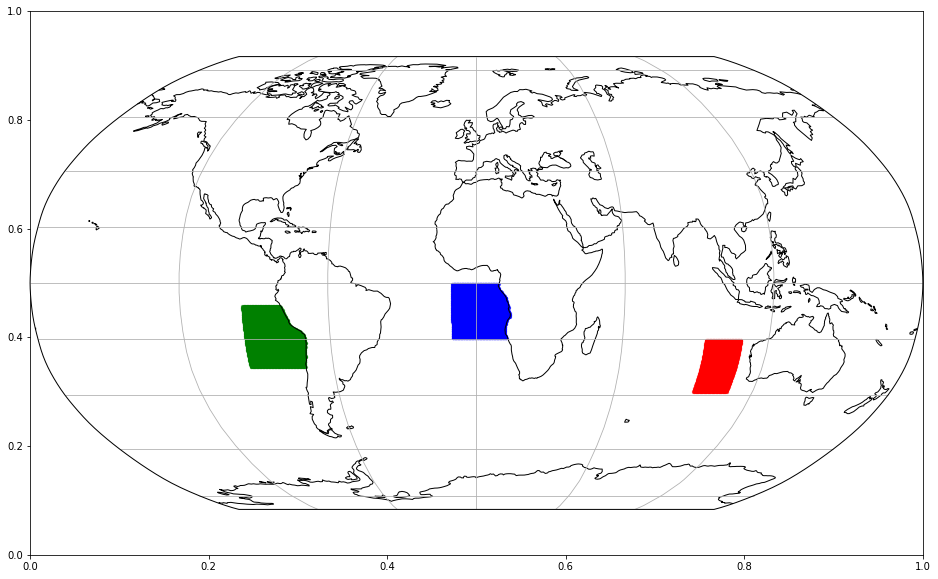

In [16]:
fig, ax = plt.subplots(figsize=(16,10))

#-- choose map projection
ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson())
ax.set_global()
#-- add coastlines, country border lines, and grid lines
ax.coastlines()
ax.gridlines()
for il in range(len(YiERA5_1d)):
    d0 = lonlat_in(YiERA5_1d[il], XiERA5_1d[il],-39,94,-20,109) # Australian
    if d0>0:
        if ERA5_lsm_1d[il]<0.05:
            plt.scatter(XiERA5_1d[il], YiERA5_1d[il],
                        color="red",
                        s=5,
                        alpha=0.5,
                        transform=ccrs.PlateCarree()) ## Important

for il in range(len(YiERA5_1d)):
    d0 = lonlat_in(YiERA5_1d[il], XiERA5_1d[il],-20,0,0,20) # Namibian
    if d0>0:
        if ERA5_lsm_1d[il]<0.05:
            plt.scatter(XiERA5_1d[il], YiERA5_1d[il],
                        color="blue",
                        s=5,
                        alpha=0.5,
                        transform=ccrs.PlateCarree()) ## Important
        
for il in range(len(YiERA5_1d)):
    d0 = lonlat_in(YiERA5_1d[il], XiERA5_1d[il],-20,350,0,360) # Namibian
    if d0>0:
        if ERA5_lsm_1d[il]<0.05:
            plt.scatter(XiERA5_1d[il], YiERA5_1d[il],
                        color="blue",
                        s=5,
                        alpha=0.5,
                        transform=ccrs.PlateCarree()) ## Important

for il in range(len(YiERA5_1d)):
    d0 = lonlat_in(YiERA5_1d[il], XiERA5_1d[il],-30,265,-8,290) # Peruvian
    if d0>0:
        if ERA5_lsm_1d[il]<0.05:
            plt.scatter(XiERA5_1d[il], YiERA5_1d[il],
                        color="green",
                        s=5,
                        alpha=0.5,
                        transform=ccrs.PlateCarree()) ## Important
plt.savefig('Ocean_Land_Namibian_Peruvian_Australian_ERA5.png')

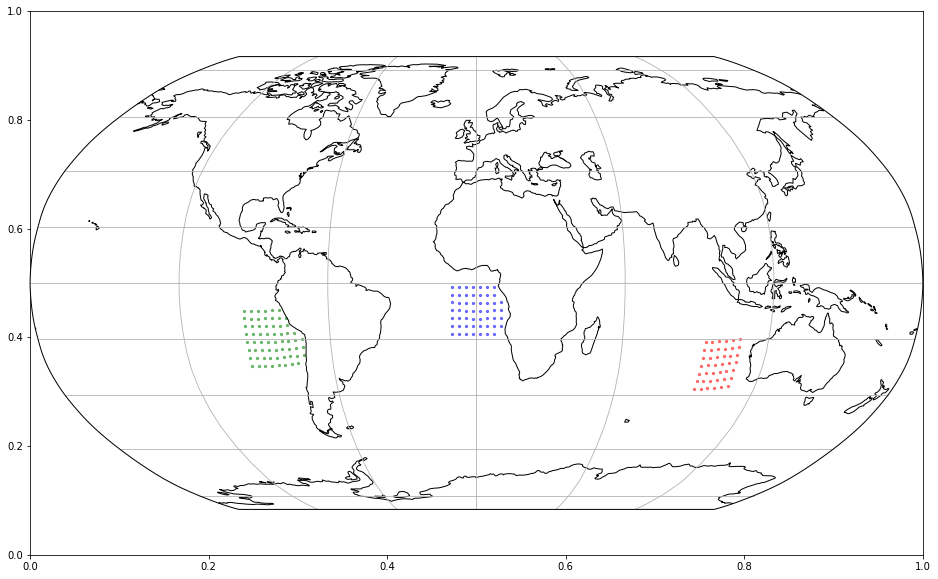

In [17]:
# Check the location of the selected column
#-- create figure and axes object
fig, ax = plt.subplots(figsize=(16,10))

#-- choose map projection
ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson())
ax.set_global()
#-- add coastlines, country border lines, and grid lines
ax.coastlines()
ax.gridlines()

ind_Namibian = [-999]        
for il in range(len(lon)):
    d0 = lonlat_in(lat[il], lon[il],-20,0,0,20) # Namibian
    if OCNFRAC[il]>0.95:
        if d0>0:
            ind_Namibian.append(il)
            plt.scatter(lon[il], lat[il],
                        color="blue",
                        s=5,
                        alpha=0.5,
                        transform=ccrs.PlateCarree()) ## Important
    d0 = lonlat_in(lat[il], lon[il],-20,350,0,360) # Namibian
    if OCNFRAC[il]>0.95:
        if d0>0:
            ind_Namibian.append(il)
            plt.scatter(lon[il], lat[il],
                        color="blue",
                        s=5,
                        alpha=0.5,
                        transform=ccrs.PlateCarree()) ## Important

ind_Peruvian = [-999]
for il in range(len(lon)):
    d0 = lonlat_in(lat[il], lon[il],-30,265,-8,290) # Peruvian
    if OCNFRAC[il]>0.5:
        if d0>0:
            ind_Peruvian.append(il)
            plt.scatter(lon[il], lat[il],
                        color="green",
                        s=5,
                        alpha=0.5,
                        transform=ccrs.PlateCarree()) ## Important

ind_Australian = [-999]
for il in range(len(lon)):
    d0 = lonlat_in(lat[il], lon[il],-39,94,-20,109) # Australian
    if d0>0:
        ind_Australian.append(il)
        plt.scatter(lon[il], lat[il],
                    color="red",
                    s=5,
                    alpha=0.5,
                    transform=ccrs.PlateCarree()) ## Important
        
        

plt.savefig('Ocean_Land_Namibian_Peruvian_Australian_Model.png')

In [18]:
ind_Peruvian = ind_Peruvian[1:]
ind_Namibian = ind_Namibian[1:]
ind_Australian = ind_Australian[1:]

# Peruvian 

In [117]:
spww_SPPeruvian = np.zeros([1009,125])
spww_UPPeruvian = np.zeros([1009,125])
spww_UPhyPeruvian = np.zeros([1009,125])
spww_UPhysedi20Peruvian = np.zeros([1009,125])
spww_UPhysedi15Peruvian = np.zeros([1009,125])
Z3_SPPeruvian = np.zeros([1009,125])
Z3_UPPeruvian = np.zeros([1009,125])
Z3_UPhyPeruvian = np.zeros([1009,125])
Z3_UPhysedi20Peruvian = np.zeros([1009,125])
Z3_UPhysedi15Peruvian = np.zeros([1009,125])
pttend_SPPeruvian = np.zeros([1009,125])
pttend_UPPeruvian = np.zeros([1009,125])
pttend_UPhyPeruvian = np.zeros([1009,125])
pttend_UPhysedi20Peruvian = np.zeros([1009,125])
pttend_UPhysedi15Peruvian = np.zeros([1009,125])
cld_SPPeruvian = np.zeros([1009,125])
cld_UPPeruvian = np.zeros([1009,125])
cld_UPhyPeruvian = np.zeros([1009,125])
cld_UPhysedi20Peruvian = np.zeros([1009,125])
cld_UPhysedi15Peruvian = np.zeros([1009,125])
T_SPPeruvian = np.zeros([1009,125])
T_UPPeruvian = np.zeros([1009,125])
T_UPhyPeruvian = np.zeros([1009,125])
T_UPhysedi20Peruvian = np.zeros([1009,125])
T_UPhysedi15Peruvian = np.zeros([1009,125])
CLDLIQ_SPPeruvian = np.zeros([1009,125])
CLDLIQ_UPPeruvian = np.zeros([1009,125])
CLDLIQ_UPhyPeruvian = np.zeros([1009,125])
CLDLIQ_UPhysedi20Peruvian = np.zeros([1009,125])
CLDLIQ_UPhysedi15Peruvian = np.zeros([1009,125])
CLDICE_SPPeruvian = np.zeros([1009,125])
CLDICE_UPPeruvian = np.zeros([1009,125])
CLDICE_UPhyPeruvian = np.zeros([1009,125])
CLDICE_UPhysedi20Peruvian = np.zeros([1009,125])
CLDICE_UPhysedi15Peruvian = np.zeros([1009,125])
Q_SPPeruvian = np.zeros([1009,125])
Q_UPPeruvian = np.zeros([1009,125])
Q_UPhyPeruvian = np.zeros([1009,125])
Q_UPhysedi20Peruvian = np.zeros([1009,125])
Q_UPhysedi15Peruvian = np.zeros([1009,125])
P_SPPeruvian = np.zeros([1009,125])
P_UPPeruvian = np.zeros([1009,125])
P_UPhyPeruvian = np.zeros([1009,125])
P_UPhysedi20Peruvian = np.zeros([1009,125])
P_UPhysedi15Peruvian = np.zeros([1009,125])
for it in range(1009):
    count = 0
    for il in range(len(ind_Peruvian)):
        spww_SPPeruvian[it,:] = spww_SPPeruvian[it,:] + SPWWSP[it,:,ind_Peruvian[il]]
        spww_UPPeruvian[it,:] = spww_UPPeruvian[it,:] + SPWWUP[it,:,ind_Peruvian[il]]
        spww_UPhyPeruvian[it,:] = spww_UPhyPeruvian[it,:] + SPWWUPhy[it,:,ind_Peruvian[il]]
        spww_UPhysedi15Peruvian[it,:] = spww_UPhysedi15Peruvian[it,:] + SPWWUPhysedi15[it,:,ind_Peruvian[il]]
        spww_UPhysedi20Peruvian[it,:] = spww_UPhysedi20Peruvian[it,:] + SPWWUPhysedi20[it,:,ind_Peruvian[il]]
        Z3_SPPeruvian[it,:] = Z3_SPPeruvian[it,:] + Z3SP[it,:,ind_Peruvian[il]]
        Z3_UPPeruvian[it,:] = Z3_UPPeruvian[it,:] + Z3UP[it,:,ind_Peruvian[il]]
        Z3_UPhyPeruvian[it,:] = Z3_UPhyPeruvian[it,:] + Z3UPhy[it,:,ind_Peruvian[il]]
        Z3_UPhysedi15Peruvian[it,:] = Z3_UPhysedi15Peruvian[it,:] + Z3UPhysedi15[it,:,ind_Peruvian[il]]
        Z3_UPhysedi20Peruvian[it,:] = Z3_UPhysedi20Peruvian[it,:] + Z3UPhysedi20[it,:,ind_Peruvian[il]]
        T_SPPeruvian[it,:] = T_SPPeruvian[it,:] + T_SP[it,:,ind_Peruvian[il]]
        T_UPPeruvian[it,:] = T_UPPeruvian[it,:] + T_UP[it,:,ind_Peruvian[il]]
        T_UPhyPeruvian[it,:] = T_UPhyPeruvian[it,:] + T_UPhy[it,:,ind_Peruvian[il]]
        T_UPhysedi15Peruvian[it,:] = T_UPhysedi15Peruvian[it,:] + T_UPhysedi15[it,:,ind_Peruvian[il]]
        T_UPhysedi20Peruvian[it,:] = T_UPhysedi20Peruvian[it,:] + T_UPhysedi20[it,:,ind_Peruvian[il]]
        CLDICE_SPPeruvian[it,:] = CLDICE_SPPeruvian[it,:] + CLDICE_SP[it,:,ind_Peruvian[il]]
        CLDICE_UPPeruvian[it,:] = CLDICE_UPPeruvian[it,:] + CLDICE_UP[it,:,ind_Peruvian[il]]
        CLDICE_UPhyPeruvian[it,:] = CLDICE_UPhyPeruvian[it,:] + CLDICE_UPhy[it,:,ind_Peruvian[il]]
        CLDICE_UPhysedi15Peruvian[it,:] = CLDICE_UPhysedi15Peruvian[it,:] + CLDICE_UPhysedi15[it,:,ind_Peruvian[il]]
        CLDICE_UPhysedi20Peruvian[it,:] = CLDICE_UPhysedi20Peruvian[it,:] + CLDICE_UPhysedi20[it,:,ind_Peruvian[il]]
        CLDLIQ_SPPeruvian[it,:] = CLDLIQ_SPPeruvian[it,:] + CLDLIQ_SP[it,:,ind_Peruvian[il]]
        CLDLIQ_UPPeruvian[it,:] = CLDLIQ_UPPeruvian[it,:] + CLDLIQ_UP[it,:,ind_Peruvian[il]]
        CLDLIQ_UPhyPeruvian[it,:] = CLDLIQ_UPhyPeruvian[it,:] + CLDLIQ_UPhy[it,:,ind_Peruvian[il]]
        CLDLIQ_UPhysedi15Peruvian[it,:] = CLDLIQ_UPhysedi15Peruvian[it,:] + CLDLIQ_UPhysedi15[it,:,ind_Peruvian[il]]
        CLDLIQ_UPhysedi20Peruvian[it,:] = CLDLIQ_UPhysedi20Peruvian[it,:] + CLDLIQ_UPhysedi20[it,:,ind_Peruvian[il]]
        Q_SPPeruvian[it,:] = Q_SPPeruvian[it,:] + Q_SP[it,:,ind_Peruvian[il]]
        Q_UPPeruvian[it,:] = Q_UPPeruvian[it,:] + Q_UP[it,:,ind_Peruvian[il]]
        Q_UPhyPeruvian[it,:] = Q_UPhyPeruvian[it,:] + Q_UPhy[it,:,ind_Peruvian[il]]
        Q_UPhysedi15Peruvian[it,:] = Q_UPhysedi15Peruvian[it,:] + Q_UPhysedi15[it,:,ind_Peruvian[il]]
        Q_UPhysedi20Peruvian[it,:] = Q_UPhysedi20Peruvian[it,:] + Q_UPhysedi20[it,:,ind_Peruvian[il]]
        pttend_SPPeruvian[it,:] = pttend_SPPeruvian[it,:] + PTTEND_SP[it,:,ind_Peruvian[il]]
        pttend_UPPeruvian[it,:] = pttend_UPPeruvian[it,:] + PTTEND_UP[it,:,ind_Peruvian[il]]
        pttend_UPhyPeruvian[it,:] = pttend_UPhyPeruvian[it,:] + PTTEND_UPhy[it,:,ind_Peruvian[il]]
        pttend_UPhysedi15Peruvian[it,:] = pttend_UPhysedi15Peruvian[it,:] + PTTEND_UPhysedi15[it,:,ind_Peruvian[il]]
        pttend_UPhysedi20Peruvian[it,:] = pttend_UPhysedi20Peruvian[it,:] + PTTEND_UPhysedi20[it,:,ind_Peruvian[il]]
        cld_SPPeruvian[it,:] = cld_SPPeruvian[it,:] + CLOUD_SP[it,:,ind_Peruvian[il]]
        cld_UPPeruvian[it,:] = cld_UPPeruvian[it,:] + CLOUD_UP[it,:,ind_Peruvian[il]]
        cld_UPhyPeruvian[it,:] = cld_UPhyPeruvian[it,:] + CLOUD_UPhy[it,:,ind_Peruvian[il]]
        cld_UPhysedi15Peruvian[it,:] = cld_UPhysedi15Peruvian[it,:] + CLOUD_UPhysedi15[it,:,ind_Peruvian[il]]
        cld_UPhysedi20Peruvian[it,:] = cld_UPhysedi20Peruvian[it,:] + CLOUD_UPhysedi20[it,:,ind_Peruvian[il]]
        P_SPPeruvian[it,:] = hyam_SP[it,:]*P0_SP[it]+hybm_SP[it,:]*PS_SP[it,il]
        P_UPPeruvian[it,:] = hyam_UP[it,:]*P0_UP[it]+hybm_UP[it,:]*PS_UP[it,il]
        P_UPhyPeruvian[it,:] = hyam_UPhy[it,:]*P0_UPhy[it]+hybm_UPhy[it,:]*PS_UPhy[it,il]
        P_UPhysedi15Peruvian[it,:] = hyam_UPhysedi15[it,:]*P0_UPhysedi15[it]+hybm_UPhysedi15[it,:]*PS_UPhysedi15[it,il]
        P_UPhysedi20Peruvian[it,:] = hyam_UPhysedi20[it,:]*P0_UPhysedi20[it]+hybm_UPhysedi20[it,:]*PS_UPhysedi20[it,il]
        count = count + 1
            
    spww_SPPeruvian[it,:] = spww_SPPeruvian[it,:] /count
    spww_UPPeruvian[it,:] = spww_UPPeruvian[it,:]  /count
    spww_UPhyPeruvian[it,:] = spww_UPhyPeruvian[it,:] /count
    spww_UPhysedi15Peruvian[it,:] = spww_UPhysedi15Peruvian[it,:] /count
    spww_UPhysedi20Peruvian[it,:] = spww_UPhysedi20Peruvian[it,:] /count
    Z3_SPPeruvian[it,:] = Z3_SPPeruvian[it,:] /count
    Z3_UPPeruvian[it,:] = Z3_UPPeruvian[it,:]  /count
    Z3_UPhyPeruvian[it,:] = Z3_UPhyPeruvian[it,:] /count
    Z3_UPhysedi15Peruvian[it,:] = Z3_UPhysedi15Peruvian[it,:] /count
    Z3_UPhysedi20Peruvian[it,:] = Z3_UPhysedi20Peruvian[it,:] /count
    T_SPPeruvian[it,:] = T_SPPeruvian[it,:] /count
    T_UPPeruvian[it,:] = T_UPPeruvian[it,:]  /count
    T_UPhyPeruvian[it,:] = T_UPhyPeruvian[it,:] /count
    T_UPhysedi15Peruvian[it,:] = T_UPhysedi15Peruvian[it,:] /count
    T_UPhysedi20Peruvian[it,:] = T_UPhysedi20Peruvian[it,:] /count
    CLDICE_SPPeruvian[it,:] = CLDICE_SPPeruvian[it,:] /count
    CLDICE_UPPeruvian[it,:] = CLDICE_UPPeruvian[it,:]  /count
    CLDICE_UPhyPeruvian[it,:] = CLDICE_UPhyPeruvian[it,:] /count
    CLDICE_UPhysedi15Peruvian[it,:] = CLDICE_UPhysedi15Peruvian[it,:] /count
    CLDICE_UPhysedi20Peruvian[it,:] = CLDICE_UPhysedi20Peruvian[it,:] /count
    CLDLIQ_SPPeruvian[it,:] = CLDLIQ_SPPeruvian[it,:] /count
    CLDLIQ_UPPeruvian[it,:] = CLDLIQ_UPPeruvian[it,:]  /count
    CLDLIQ_UPhyPeruvian[it,:] = CLDLIQ_UPhyPeruvian[it,:] /count
    CLDLIQ_UPhysedi15Peruvian[it,:] = CLDLIQ_UPhysedi15Peruvian[it,:] /count
    CLDLIQ_UPhysedi20Peruvian[it,:] = CLDLIQ_UPhysedi20Peruvian[it,:] /count
    Q_SPPeruvian[it,:] = Q_SPPeruvian[it,:] /count
    Q_UPPeruvian[it,:] = Q_UPPeruvian[it,:]  /count
    Q_UPhyPeruvian[it,:] = Q_UPhyPeruvian[it,:] /count
    Q_UPhysedi15Peruvian[it,:] = Q_UPhysedi15Peruvian[it,:] /count
    Q_UPhysedi20Peruvian[it,:] = Q_UPhysedi20Peruvian[it,:] /count
    pttend_SPPeruvian[it,:] = pttend_SPPeruvian[it,:] /count
    pttend_UPPeruvian[it,:] = pttend_UPPeruvian[it,:]  /count
    pttend_UPhyPeruvian[it,:] = pttend_UPhyPeruvian[it,:] /count
    pttend_UPhysedi15Peruvian[it,:] = pttend_UPhysedi15Peruvian[it,:] /count
    pttend_UPhysedi20Peruvian[it,:] = pttend_UPhysedi20Peruvian[it,:] /count
    cld_SPPeruvian[it,:] = cld_SPPeruvian[it,:] /count
    cld_UPPeruvian[it,:] = cld_UPPeruvian[it,:]  /count
    cld_UPhyPeruvian[it,:] = cld_UPhyPeruvian[it,:] /count
    cld_UPhysedi15Peruvian[it,:] = cld_UPhysedi15Peruvian[it,:] /count
    cld_UPhysedi20Peruvian[it,:] = cld_UPhysedi20Peruvian[it,:] /count
    P_SPPeruvian[it,:] = P_SPPeruvian[it,:] /count
    P_UPPeruvian[it,:] = P_UPPeruvian[it,:]  /count
    P_UPhyPeruvian[it,:] = P_UPhyPeruvian[it,:] /count
    P_UPhysedi15Peruvian[it,:] = P_UPhysedi15Peruvian[it,:] /count
    P_UPhysedi20Peruvian[it,:] = P_UPhysedi20Peruvian[it,:] /count
    
spww_crossSPPeruvian = np.transpose(spww_SPPeruvian)
spww_crossUPPeruvian = np.transpose(spww_UPPeruvian)
spww_crossUPhyPeruvian = np.transpose(spww_UPhyPeruvian)
spww_crossUPhysedi15Peruvian = np.transpose(spww_UPhysedi15Peruvian)
spww_crossUPhysedi20Peruvian = np.transpose(spww_UPhysedi20Peruvian)
Z3_crossSPPeruvian = np.transpose(Z3_SPPeruvian)
Z3_crossUPPeruvian = np.transpose(Z3_UPPeruvian)
Z3_crossUPhyPeruvian = np.transpose(Z3_UPhyPeruvian)
Z3_crossUPhysedi15Peruvian = np.transpose(Z3_UPhysedi15Peruvian)
Z3_crossUPhysedi20Peruvian = np.transpose(Z3_UPhysedi20Peruvian)
T_crossSPPeruvian = np.transpose(T_SPPeruvian)
T_crossUPPeruvian = np.transpose(T_UPPeruvian)
T_crossUPhyPeruvian = np.transpose(T_UPhyPeruvian)
T_crossUPhysedi15Peruvian = np.transpose(T_UPhysedi15Peruvian)
T_crossUPhysedi20Peruvian = np.transpose(T_UPhysedi20Peruvian)
CLDICE_crossSPPeruvian = np.transpose(CLDICE_SPPeruvian)
CLDICE_crossUPPeruvian = np.transpose(CLDICE_UPPeruvian)
CLDICE_crossUPhyPeruvian = np.transpose(CLDICE_UPhyPeruvian)
CLDICE_crossUPhysedi15Peruvian = np.transpose(CLDICE_UPhysedi15Peruvian)
CLDICE_crossUPhysedi20Peruvian = np.transpose(CLDICE_UPhysedi20Peruvian)
CLDLIQ_crossSPPeruvian = np.transpose(CLDLIQ_SPPeruvian)
CLDLIQ_crossUPPeruvian = np.transpose(CLDLIQ_UPPeruvian)
CLDLIQ_crossUPhyPeruvian = np.transpose(CLDLIQ_UPhyPeruvian)
CLDLIQ_crossUPhysedi15Peruvian = np.transpose(CLDLIQ_UPhysedi15Peruvian)
CLDLIQ_crossUPhysedi20Peruvian = np.transpose(CLDLIQ_UPhysedi20Peruvian)
Q_crossSPPeruvian = np.transpose(Q_SPPeruvian)
Q_crossUPPeruvian = np.transpose(Q_UPPeruvian)
Q_crossUPhyPeruvian = np.transpose(Q_UPhyPeruvian)
Q_crossUPhysedi15Peruvian = np.transpose(Q_UPhysedi15Peruvian)
Q_crossUPhysedi20Peruvian = np.transpose(Q_UPhysedi20Peruvian)
pttend_crossSPPeruvian = np.transpose(pttend_SPPeruvian)
pttend_crossUPPeruvian = np.transpose(pttend_UPPeruvian)
pttend_crossUPhyPeruvian = np.transpose(pttend_UPhyPeruvian)
pttend_crossUPhysedi15Peruvian = np.transpose(pttend_UPhysedi15Peruvian)
pttend_crossUPhysedi20Peruvian = np.transpose(pttend_UPhysedi20Peruvian)
cld_crossSPPeruvian = np.transpose(cld_SPPeruvian)
cld_crossUPPeruvian = np.transpose(cld_UPPeruvian)
cld_crossUPhyPeruvian = np.transpose(cld_UPhyPeruvian)
cld_crossUPhysedi15Peruvian = np.transpose(cld_UPhysedi15Peruvian)
cld_crossUPhysedi20Peruvian = np.transpose(cld_UPhysedi20Peruvian)
P_crossSPPeruvian = np.transpose(P_SPPeruvian)
P_crossUPPeruvian = np.transpose(P_UPPeruvian)
P_crossUPhyPeruvian = np.transpose(P_UPhyPeruvian)
P_crossUPhysedi15Peruvian = np.transpose(P_UPhysedi15Peruvian)
P_crossUPhysedi20Peruvian = np.transpose(P_UPhysedi20Peruvian)

In [101]:
P_crossUPhysedi15Peruvian.shape

(125, 1009)

In [22]:
countt = 0
temp3d = np.zeros([16,721,1440])
temp3d2 = np.zeros([16,721,1440])
temp3d3 = np.zeros([16,721,1440])
temp3d4 = np.zeros([16,721,1440])
temp = np.zeros([721,1440])
temp2 = np.zeros([721,1440])
temp3 = np.zeros([721,1440])
temp4 = np.zeros([721,1440])
ERA5_tPeruvian = np.zeros([24*7,16])
ERA5_qPeruvian = np.zeros([24*7,16])
ERA5_zPeruvian = np.zeros([24*7,16])
ERA5_ccPeruvian = np.zeros([24*7,16])
ERA_Time = np.zeros([24*7,16])
for iday in range(7):
    print(iday)
    for ihour in range(24):
        temp3d[:,:,:] = ERA5_thourly[countt,:,:]
        temp3d2[:,:,:] = ERA5_zhourly[countt,:,:]
        temp3d3[:,:,:] = ERA5_cchourly[countt,:,:]
        temp3d4[:,:,:] = ERA5_qhourly[countt,:,:]
        for iz in range(16):
            temp[:,:] = temp3d[iz,:,:]
            temp2[:,:] = temp3d2[iz,:,:]
            temp3[:,:] = temp3d3[iz,:,:]
            temp4[:,:] = temp3d3[iz,:,:]
            temp1d = temp.flatten()
            temp1d2 = temp2.flatten()
            temp1d3 = temp3.flatten()
            temp1d4 = temp4.flatten()
            counttt3 = 0
            for il in range(len(ind_Peruvian_ERA5)):
                ERA5_tPeruvian[countt,iz] = ERA5_tPeruvian[countt,iz] + temp1d[ind_Peruvian_ERA5[il]]
                ERA5_zPeruvian[countt,iz] = ERA5_zPeruvian[countt,iz] + temp1d2[ind_Peruvian_ERA5[il]]
                ERA5_ccPeruvian[countt,iz] = ERA5_ccPeruvian[countt,iz] + temp1d3[ind_Peruvian_ERA5[il]]
                ERA5_qPeruvian[countt,iz] = ERA5_qPeruvian[countt,iz] + temp1d4[ind_Peruvian_ERA5[il]]
                counttt3 = counttt3 + 1        
            ERA5_tPeruvian[countt,iz] = ERA5_tPeruvian[countt,iz]/(counttt3+1)
            ERA5_zPeruvian[countt,iz] = ERA5_zPeruvian[countt,iz]/(counttt3+1)
            ERA5_ccPeruvian[countt,iz] = ERA5_ccPeruvian[countt,iz]/(counttt3+1)
            ERA5_qPeruvian[countt,iz] = ERA5_qPeruvian[countt,iz]/counttt3+1)
            ERA_Time[countt,iz] = iday + ihour/24
        countt = countt+1

0
1
2
3
4
5
6


In [98]:
T_crossSPPeruvian.shape

(125, 1009)

0
24
1
24
2
24
3
24
4
24
5
24
6
24


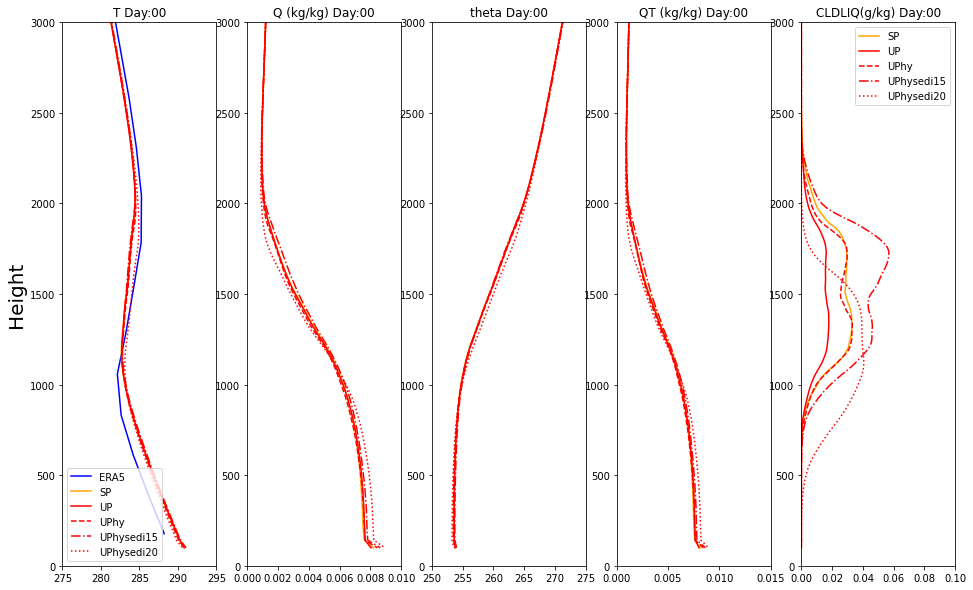

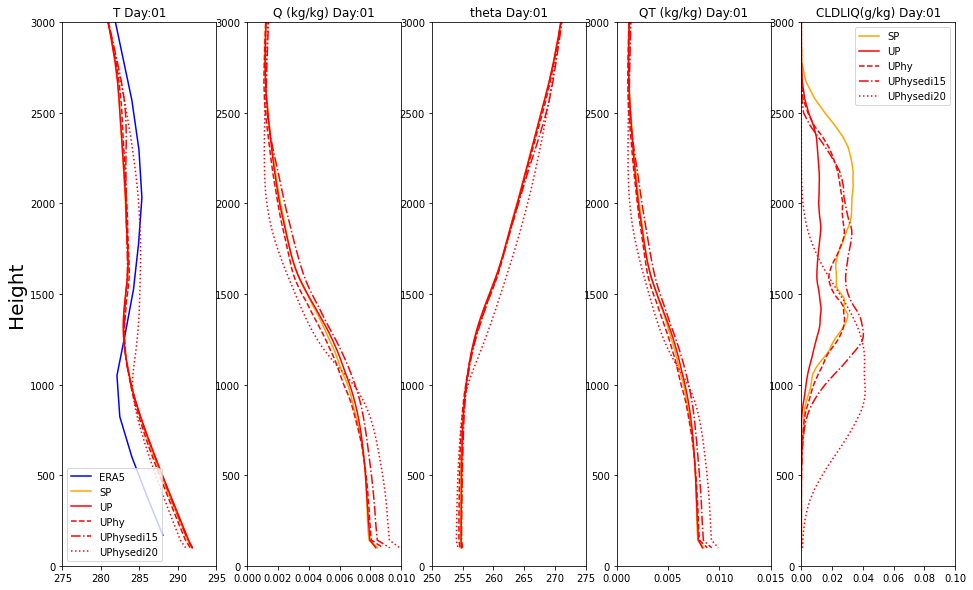

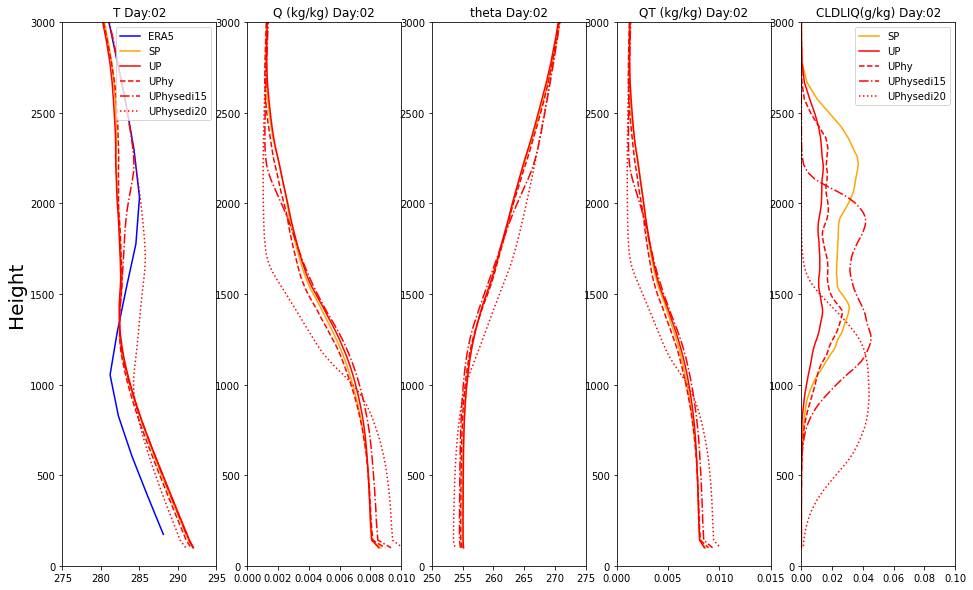

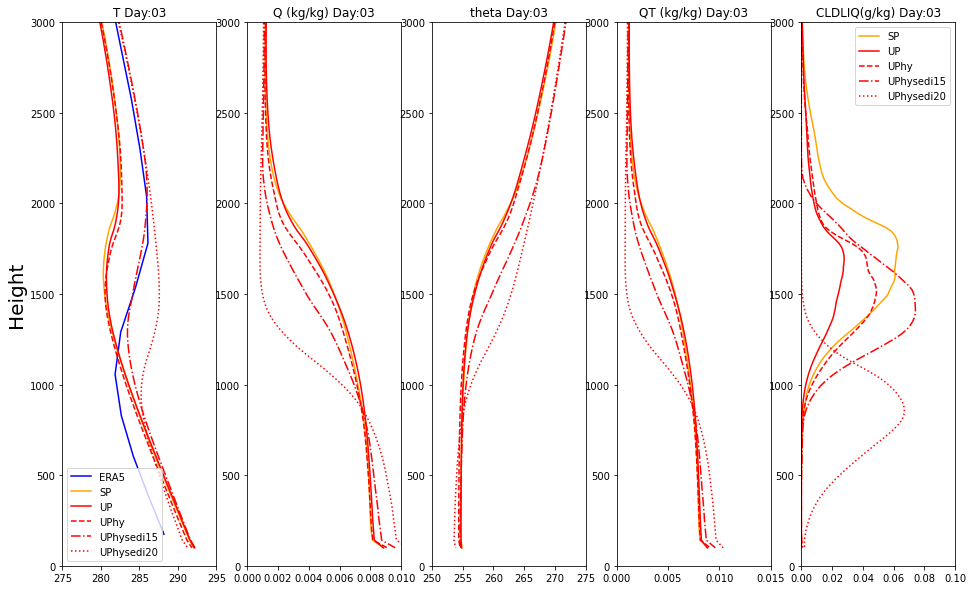

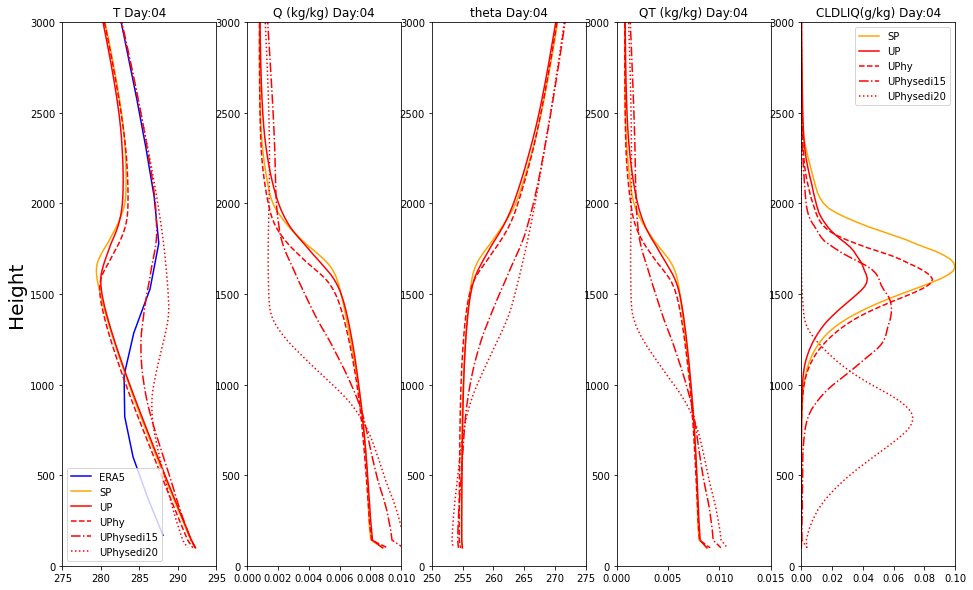

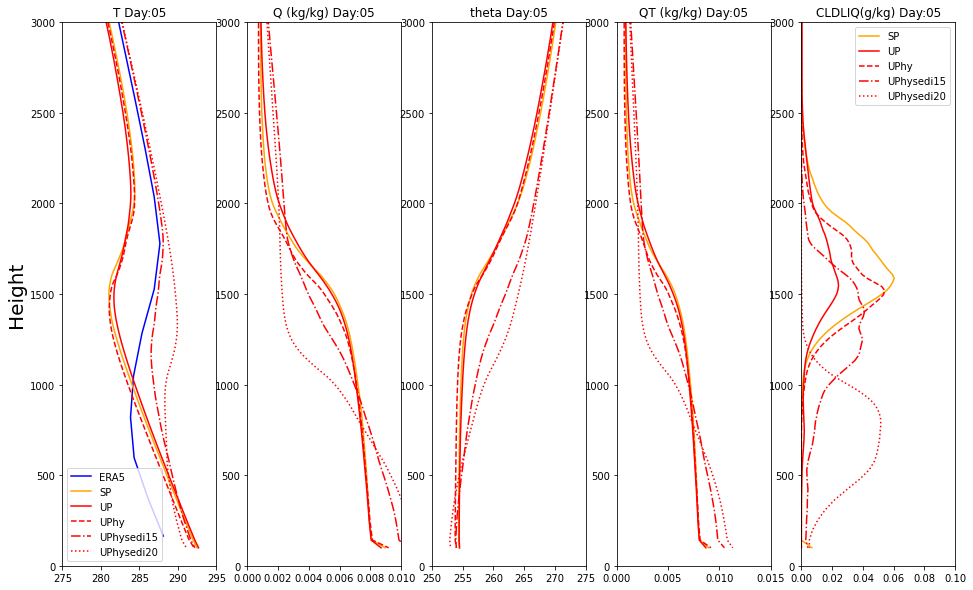

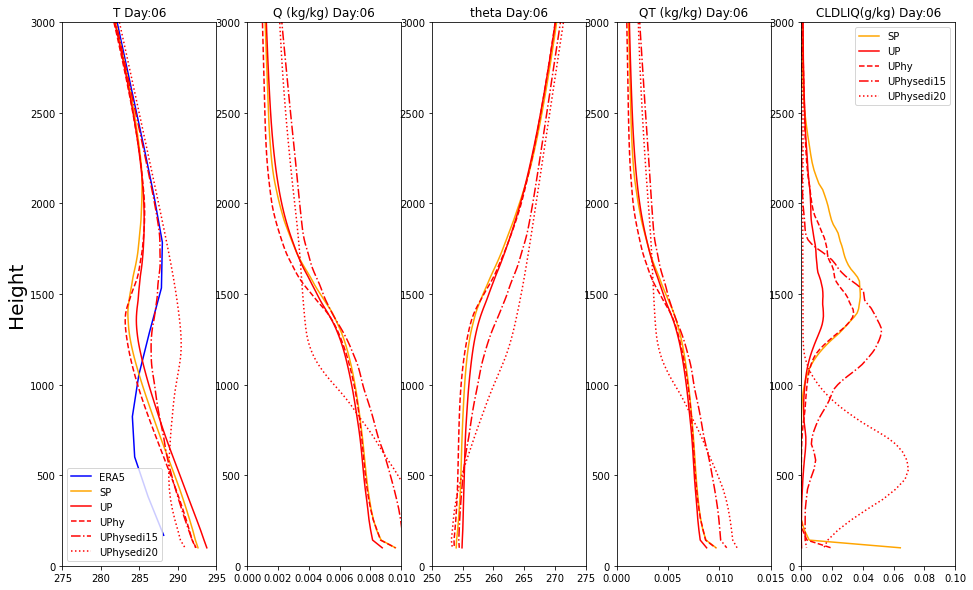

In [140]:
ERA5_pressure = [500, 550, 600, 650, 700, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000]
for iday in range(8):
    countday = 0
    T_crossERA5Peruvian_dm = np.zeros([16])
    q_crossERA5Peruvian_dm = np.zeros([16])
    z_crossERA5Peruvian_dm = np.zeros([16])
    theta_crossERA5Peruvian_dm = np.zeros([16])
    print(iday)
    for ihour in range(24):
        T_crossERA5Peruvian_dm[:] = T_crossERA5Peruvian_dm[:] + ERA5_tPeruvian[(countday+24*iday),:]
        q_crossERA5Peruvian_dm[:] = q_crossERA5Peruvian_dm[:] + ERA5_qPeruvian[(countday+24*iday),:]
        z_crossERA5Peruvian_dm[:] = z_crossERA5Peruvian_dm[:] + ERA5_zPeruvian[(countday+24*iday),:]
        for izz in range(16):
            theta_crossERA5Peruvian_dm[izz] = potential_temperature(T_crossERA5Peruvian_dm[izz],ERA5_pressure[izz]*100)
            
        countday = countday+1
    print(countday)
    T_crossERA5Peruvian_dm[:] = T_crossERA5Peruvian_dm[:]/(countday)
    q_crossERA5Peruvian_dm[:] = q_crossERA5Peruvian_dm[:]/(countday)
    z_crossERA5Peruvian_dm[:] = z_crossERA5Peruvian_dm[:]/(countday)
    theta_crossERA5Peruvian_dm[:] = theta_crossERA5Peruvian_dm[:]/(countday)
    T_crossSPPeruvian_dm = np.zeros([125])
    T_crossUPPeruvian_dm = np.zeros([125])
    T_crossUPhyPeruvian_dm = np.zeros([125])
    T_crossUPhysedi15Peruvian_dm = np.zeros([125])
    T_crossUPhysedi20Peruvian_dm = np.zeros([125])
    Q_crossSPPeruvian_dm = np.zeros([125])
    Q_crossUPPeruvian_dm = np.zeros([125])
    Q_crossUPhyPeruvian_dm = np.zeros([125])
    Q_crossUPhysedi15Peruvian_dm = np.zeros([125])
    Q_crossUPhysedi20Peruvian_dm = np.zeros([125])
    CLDICE_crossSPPeruvian_dm = np.zeros([125])
    CLDICE_crossUPPeruvian_dm = np.zeros([125])
    CLDICE_crossUPhyPeruvian_dm = np.zeros([125])
    CLDICE_crossUPhysedi15Peruvian_dm = np.zeros([125])
    CLDICE_crossUPhysedi20Peruvian_dm = np.zeros([125])
    CLDLIQ_crossSPPeruvian_dm = np.zeros([125])
    CLDLIQ_crossUPPeruvian_dm = np.zeros([125])
    CLDLIQ_crossUPhyPeruvian_dm = np.zeros([125])
    CLDLIQ_crossUPhysedi15Peruvian_dm = np.zeros([125])
    CLDLIQ_crossUPhysedi20Peruvian_dm = np.zeros([125])
    Z3_crossSPPeruvian_dm = np.zeros([125])
    Z3_crossUPPeruvian_dm = np.zeros([125])
    Z3_crossUPhyPeruvian_dm = np.zeros([125])
    Z3_crossUPhysedi15Peruvian_dm = np.zeros([125])
    Z3_crossUPhysedi20Peruvian_dm = np.zeros([125])
    theta_crossSPPeruvian_dm = np.zeros([125])
    theta_crossUPPeruvian_dm = np.zeros([125])
    theta_crossUPhyPeruvian_dm = np.zeros([125])
    theta_crossUPhysedi15Peruvian_dm = np.zeros([125])
    theta_crossUPhysedi20Peruvian_dm = np.zeros([125])
    countsec = 0
    for isec in range(144):
        T_crossSPPeruvian_dm[:] = T_crossSPPeruvian_dm[:] + T_crossSPPeruvian[:,isec+144*iday]
        T_crossUPPeruvian_dm[:] = T_crossUPPeruvian_dm[:] + T_crossUPPeruvian[:,isec+144*iday]
        T_crossUPhyPeruvian_dm[:] = T_crossUPhyPeruvian_dm[:] + T_crossUPhyPeruvian[:,isec+144*iday]
        T_crossUPhysedi15Peruvian_dm[:] = T_crossUPhysedi15Peruvian_dm[:] + T_crossUPhysedi15Peruvian[:,isec+144*iday]
        T_crossUPhysedi20Peruvian_dm[:] = T_crossUPhysedi20Peruvian_dm[:] + T_crossUPhysedi20Peruvian[:,isec+144*iday]
        Q_crossSPPeruvian_dm[:] = Q_crossSPPeruvian_dm[:] + Q_crossSPPeruvian[:,isec+144*iday]
        Q_crossUPPeruvian_dm[:] = Q_crossUPPeruvian_dm[:] + Q_crossUPPeruvian[:,isec+144*iday]
        Q_crossUPhyPeruvian_dm[:] = Q_crossUPhyPeruvian_dm[:] + Q_crossUPhyPeruvian[:,isec+144*iday]
        Q_crossUPhysedi15Peruvian_dm[:] = Q_crossUPhysedi15Peruvian_dm[:] + Q_crossUPhysedi15Peruvian[:,isec+144*iday]
        Q_crossUPhysedi20Peruvian_dm[:] = Q_crossUPhysedi20Peruvian_dm[:] + Q_crossUPhysedi20Peruvian[:,isec+144*iday]
        CLDLIQ_crossSPPeruvian_dm[:] = CLDLIQ_crossSPPeruvian_dm[:] + CLDLIQ_crossSPPeruvian[:,isec+144*iday]
        CLDLIQ_crossUPPeruvian_dm[:] = CLDLIQ_crossUPPeruvian_dm[:] + CLDLIQ_crossUPPeruvian[:,isec+144*iday]
        CLDLIQ_crossUPhyPeruvian_dm[:] = CLDLIQ_crossUPhyPeruvian_dm[:] + CLDLIQ_crossUPhyPeruvian[:,isec+144*iday]
        CLDLIQ_crossUPhysedi15Peruvian_dm[:] = CLDLIQ_crossUPhysedi15Peruvian_dm[:] + CLDLIQ_crossUPhysedi15Peruvian[:,isec+144*iday]
        CLDLIQ_crossUPhysedi20Peruvian_dm[:] = CLDLIQ_crossUPhysedi20Peruvian_dm[:] + CLDLIQ_crossUPhysedi20Peruvian[:,isec+144*iday]
        CLDICE_crossSPPeruvian_dm[:] = CLDICE_crossSPPeruvian_dm[:] + CLDICE_crossSPPeruvian[:,isec+144*iday]
        CLDICE_crossUPPeruvian_dm[:] = CLDICE_crossUPPeruvian_dm[:] + CLDICE_crossUPPeruvian[:,isec+144*iday]
        CLDICE_crossUPhyPeruvian_dm[:] = CLDICE_crossUPhyPeruvian_dm[:] + CLDICE_crossUPhyPeruvian[:,isec+144*iday]
        CLDICE_crossUPhysedi15Peruvian_dm[:] = CLDICE_crossUPhysedi15Peruvian_dm[:] + CLDICE_crossUPhysedi15Peruvian[:,isec+144*iday]
        CLDICE_crossUPhysedi20Peruvian_dm[:] = CLDICE_crossUPhysedi20Peruvian_dm[:] + CLDICE_crossUPhysedi20Peruvian[:,isec+144*iday]
        Z3_crossSPPeruvian_dm[:] = Z3_crossSPPeruvian_dm[:] + Z3_crossSPPeruvian[:,isec+144*iday]
        Z3_crossUPPeruvian_dm[:] = Z3_crossUPPeruvian_dm[:] + Z3_crossUPPeruvian[:,isec+144*iday]
        Z3_crossUPhyPeruvian_dm[:] = Z3_crossUPhyPeruvian_dm[:] + Z3_crossUPhyPeruvian[:,isec+144*iday]
        Z3_crossUPhysedi15Peruvian_dm[:] = Z3_crossUPhysedi15Peruvian_dm[:] + Z3_crossUPhysedi15Peruvian[:,isec+144*iday]
        Z3_crossUPhysedi20Peruvian_dm[:] = Z3_crossUPhysedi20Peruvian_dm[:] + Z3_crossUPhysedi20Peruvian[:,isec+144*iday]
        for izz in range(125):
            theta_crossSPPeruvian_dm[izz] = theta_crossSPPeruvian_dm[izz] + potential_temperature(T_crossSPPeruvian[izz,isec+144*iday],P_crossSPPeruvian[izz,isec+144*iday]*100)
            theta_crossUPPeruvian_dm[izz] = theta_crossUPPeruvian_dm[izz] + potential_temperature(T_crossUPPeruvian[izz,isec+144*iday],P_crossUPPeruvian[izz,isec+144*iday]*100)
            theta_crossUPhyPeruvian_dm[izz] = theta_crossUPhyPeruvian_dm[izz] + potential_temperature(T_crossUPhyPeruvian[izz,isec+144*iday],P_crossUPhyPeruvian[izz,isec+144*iday]*100)
            theta_crossUPhysedi15Peruvian_dm[izz] = theta_crossUPhysedi15Peruvian_dm[izz] + potential_temperature(T_crossUPhysedi15Peruvian[izz,isec+144*iday],P_crossUPhysedi15Peruvian[izz,isec+144*iday]*100)
            theta_crossUPhysedi20Peruvian_dm[izz] = theta_crossUPhysedi20Peruvian_dm[izz] + potential_temperature(T_crossUPhysedi20Peruvian[izz,isec+144*iday],P_crossUPhysedi20Peruvian[izz,isec+144*iday]*100)
        countsec = countsec+1
    T_crossSPPeruvian_dm = T_crossSPPeruvian_dm/(countsec)
    T_crossUPPeruvian_dm = T_crossUPPeruvian_dm/(countsec)
    T_crossUPhyPeruvian_dm = T_crossUPhyPeruvian_dm/(countsec)
    T_crossUPhysedi15Peruvian_dm = T_crossUPhysedi15Peruvian_dm/(countsec)
    T_crossUPhysedi20Peruvian_dm = T_crossUPhysedi20Peruvian_dm/(countsec)
    Q_crossSPPeruvian_dm = Q_crossSPPeruvian_dm/(countsec)
    Q_crossUPPeruvian_dm = Q_crossUPPeruvian_dm/(countsec)
    Q_crossUPhyPeruvian_dm = Q_crossUPhyPeruvian_dm/(countsec)
    Q_crossUPhysedi15Peruvian_dm = Q_crossUPhysedi15Peruvian_dm/(countsec)
    Q_crossUPhysedi20Peruvian_dm = Q_crossUPhysedi20Peruvian_dm/(countsec)  
    CLDICE_crossSPPeruvian_dm = CLDICE_crossSPPeruvian_dm/(countsec)
    CLDICE_crossUPPeruvian_dm = CLDICE_crossUPPeruvian_dm/(countsec)
    CLDICE_crossUPhyPeruvian_dm = CLDICE_crossUPhyPeruvian_dm/(countsec)
    CLDICE_crossUPhysedi15Peruvian_dm = CLDICE_crossUPhysedi15Peruvian_dm/(countsec)
    CLDICE_crossUPhysedi20Peruvian_dm = CLDICE_crossUPhysedi20Peruvian_dm/(countsec)  
    CLDLIQ_crossSPPeruvian_dm = CLDLIQ_crossSPPeruvian_dm/(countsec)
    CLDLIQ_crossUPPeruvian_dm = CLDLIQ_crossUPPeruvian_dm/(countsec)
    CLDLIQ_crossUPhyPeruvian_dm = CLDLIQ_crossUPhyPeruvian_dm/(countsec)
    CLDLIQ_crossUPhysedi15Peruvian_dm = CLDLIQ_crossUPhysedi15Peruvian_dm/(countsec)
    CLDLIQ_crossUPhysedi20Peruvian_dm = CLDLIQ_crossUPhysedi20Peruvian_dm/(countsec)  
    Z3_crossSPPeruvian_dm = Z3_crossSPPeruvian_dm/(countsec)
    Z3_crossUPPeruvian_dm = Z3_crossUPPeruvian_dm/(countsec)
    Z3_crossUPhyPeruvian_dm = Z3_crossUPhyPeruvian_dm/(countsec)
    Z3_crossUPhysedi15Peruvian_dm = Z3_crossUPhysedi15Peruvian_dm/(countsec)
    Z3_crossUPhysedi20Peruvian_dm = Z3_crossUPhysedi20Peruvian_dm/(countsec) 
    theta_crossSPPeruvian_dm = theta_crossSPPeruvian_dm/(countsec)
    theta_crossUPPeruvian_dm = theta_crossUPPeruvian_dm/(countsec)
    theta_crossUPhyPeruvian_dm = theta_crossUPhyPeruvian_dm/(countsec)
    theta_crossUPhysedi15Peruvian_dm = theta_crossUPhysedi15Peruvian_dm/(countsec)
    theta_crossUPhysedi20Peruvian_dm = theta_crossUPhysedi20Peruvian_dm/(countsec)
    fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(nrows=1, ncols=5, figsize=(16, 10))   
    cf01 = ax1.plot(T_crossERA5Peruvian_dm,z_crossERA5Peruvian_dm/9.8, color='blue', label = 'ERA5')
    cf02 = ax1.plot(T_crossSPPeruvian_dm,Z3_crossSPPeruvian_dm, color='orange', label = 'SP')
    cf03 = ax1.plot(T_crossUPPeruvian_dm,Z3_crossUPPeruvian_dm, color='red', label = 'UP')
    cf04 = ax1.plot(T_crossUPhyPeruvian_dm,Z3_crossUPhyPeruvian_dm, color='red', linestyle='dashed', label = 'UPhy')
    cf05 = ax1.plot(T_crossUPhysedi15Peruvian_dm,Z3_crossUPhysedi15Peruvian_dm, color='red', linestyle='dashdot', label = 'UPhysedi15')
    cf06 = ax1.plot(T_crossUPhysedi20Peruvian_dm,Z3_crossUPhysedi20Peruvian_dm, color='red', linestyle='dotted', label = 'UPhysedi20')
    ax1.legend(prop ={'size': 10})
    ax1.set(xlim=(275, 295), ylim=(0, 3000))
    title1 = 'T Day:'+'{:02d}'
    ax1.set_title(title1.format(iday))
    #ax1.set_xlabel('Day', fontsize=20)
    ax1.set_ylabel('Height', fontsize=20)
    
    #cf02 = ax2.plot(q_crossERA5Peruvian_dm,z_crossERA5Peruvian_dm/9.8)
    cf12 = ax2.plot(Q_crossSPPeruvian_dm,Z3_crossSPPeruvian_dm, color='orange')
    cf13 = ax2.plot(Q_crossUPPeruvian_dm,Z3_crossUPPeruvian_dm, color='red')
    cf14 = ax2.plot(Q_crossUPhyPeruvian_dm,Z3_crossUPhyPeruvian_dm, color='red', linestyle='dashed')
    cf15 = ax2.plot(Q_crossUPhysedi15Peruvian_dm,Z3_crossUPhysedi15Peruvian_dm, color='red', linestyle='dashdot')
    cf16 = ax2.plot(Q_crossUPhysedi20Peruvian_dm,Z3_crossUPhysedi20Peruvian_dm, color='red', linestyle='dotted')
    ax2.set(xlim=(0, 0.010), ylim=(0, 3000))
    title2 = 'Q (kg/kg) Day:'+'{:02d}'
    ax2.set_title(title2.format(iday))
    #ax1.set_xlabel('Day', fontsize=20)
    #ax2.set_ylabel('Height', fontsize=20)
    
    cf31 = ax3.plot(theta_crossERA5Peruvian_dm,z_crossERA5Peruvian_dm/9.8)
    cf32 = ax3.plot(theta_crossSPPeruvian_dm,Z3_crossSPPeruvian_dm, color='orange')
    cf33 = ax3.plot(theta_crossUPPeruvian_dm,Z3_crossUPPeruvian_dm, color='red')
    cf34 = ax3.plot(theta_crossUPhyPeruvian_dm,Z3_crossUPhyPeruvian_dm, color='red', linestyle='dashed')
    cf35 = ax3.plot(theta_crossUPhysedi15Peruvian_dm,Z3_crossUPhysedi15Peruvian_dm, color='red', linestyle='dashdot')
    cf36 = ax3.plot(theta_crossUPhysedi20Peruvian_dm,Z3_crossUPhysedi20Peruvian_dm, color='red', linestyle='dotted')
    ax3.set(xlim=(250, 275), ylim=(0, 3000))
    title3 = 'theta Day:'+'{:02d}'
    ax3.set_title(title3.format(iday))
    #ax1.set_xlabel('Day', fontsize=20)
    #ax3.set_ylabel('Height', fontsize=20)
    
    QT_crossSPPeruvian_dm = Q_crossSPPeruvian_dm+CLDICE_crossSPPeruvian_dm+CLDLIQ_crossSPPeruvian_dm
    QT_crossUPPeruvian_dm = Q_crossUPPeruvian_dm+CLDICE_crossUPPeruvian_dm+CLDLIQ_crossUPPeruvian_dm
    QT_crossUPhyPeruvian_dm = Q_crossUPhyPeruvian_dm+CLDICE_crossUPhyPeruvian_dm+CLDLIQ_crossUPhyPeruvian_dm
    QT_crossUPhysedi15Peruvian_dm = Q_crossUPhysedi15Peruvian_dm+CLDICE_crossUPhysedi15Peruvian_dm+CLDLIQ_crossUPhysedi15Peruvian_dm
    QT_crossUPhysedi20Peruvian_dm = Q_crossUPhysedi20Peruvian_dm+CLDICE_crossUPhysedi20Peruvian_dm+CLDLIQ_crossUPhysedi20Peruvian_dm
    cf42 = ax4.plot(QT_crossSPPeruvian_dm,Z3_crossSPPeruvian_dm, color='orange')
    cf43 = ax4.plot(QT_crossUPPeruvian_dm,Z3_crossUPPeruvian_dm, color='red')
    cf44 = ax4.plot(QT_crossUPhyPeruvian_dm,Z3_crossUPhyPeruvian_dm, color='red', linestyle='dashed')
    cf45 = ax4.plot(QT_crossUPhysedi15Peruvian_dm,Z3_crossUPhysedi15Peruvian_dm, color='red', linestyle='dashdot')
    cf46 = ax4.plot(QT_crossUPhysedi20Peruvian_dm,Z3_crossUPhysedi20Peruvian_dm, color='red', linestyle='dotted')
    ax4.set(xlim=(0, 0.015), ylim=(0, 3000))
    title1 = 'QT (kg/kg) Day:'+'{:02d}'
    ax4.set_title(title1.format(iday))
    #ax4.set_xlabel('Day', fontsize=20)
    #ax4.set_ylabel('Height', fontsize=20)    
    
    cf52 = ax5.plot(1000*CLDLIQ_crossSPPeruvian_dm,Z3_crossSPPeruvian_dm, color='orange', label = 'SP')
    cf53 = ax5.plot(1000*CLDLIQ_crossUPPeruvian_dm,Z3_crossUPPeruvian_dm, color='red', label = 'UP')
    cf54 = ax5.plot(1000*CLDLIQ_crossUPhyPeruvian_dm,Z3_crossUPhyPeruvian_dm, color='red', linestyle='dashed', label = 'UPhy')
    cf55 = ax5.plot(1000*CLDLIQ_crossUPhysedi15Peruvian_dm,Z3_crossUPhysedi15Peruvian_dm, color='red', linestyle='dashdot', label = 'UPhysedi15')
    cf56 = ax5.plot(1000*CLDLIQ_crossUPhysedi20Peruvian_dm,Z3_crossUPhysedi20Peruvian_dm, color='red', linestyle='dotted', label = 'UPhysedi20')
    ax5.set(xlim=(0, 0.10), ylim=(0, 3000))
    ax5.legend(prop ={'size': 10})
    title2 = 'CLDLIQ(g/kg) Day:'+'{:02d}'
    ax5.set_title(title2.format(iday))
    titlefigure = 'Peruvian_Profiles_Day'+'{:02d}'+'.png'
    plt.savefig(titlefigure.format(iday))

In [113]:
print(Q_crossUPhyPeruvian_dm)

[2.53886888e-08 2.52630821e-08 2.43478394e-08 2.28630298e-08
 2.17462536e-08 2.10296129e-08 2.04610832e-08 1.98661213e-08
 1.97170449e-08 1.96744141e-08 1.95903146e-08 1.93252420e-08
 1.89943461e-08 1.86333151e-08 1.84130390e-08 1.83451830e-08
 1.83696817e-08 1.86149035e-08 1.96351465e-08 2.20450491e-08
 2.46973480e-08 2.56928510e-08 2.73600291e-08 3.49800340e-08
 5.91818076e-08 1.21908036e-07 2.37947952e-07 3.98642844e-07
 5.78524755e-07 8.61500789e-07 1.34286959e-06 2.01370542e-06
 2.71248675e-06 3.57890935e-06 4.41937474e-06 5.03290472e-06
 5.72024518e-06 6.43832991e-06 7.11676049e-06 7.71326318e-06
 8.21843097e-06 8.71783896e-06 9.16405504e-06 9.56253490e-06
 9.90221999e-06 1.01722516e-05 1.03971833e-05 1.05994578e-05
 1.08045822e-05 1.10112972e-05 1.12313584e-05 1.14614844e-05
 1.17127230e-05 1.19583521e-05 1.21825347e-05 1.23973535e-05
 1.26093438e-05 1.28324272e-05 1.31028598e-05 1.34330627e-05
 1.38273163e-05 1.42891754e-05 1.47761228e-05 1.52459884e-05
 1.57165184e-05 1.621185

In [46]:
T_crossSPPeruvian.shape

(125, 1009)

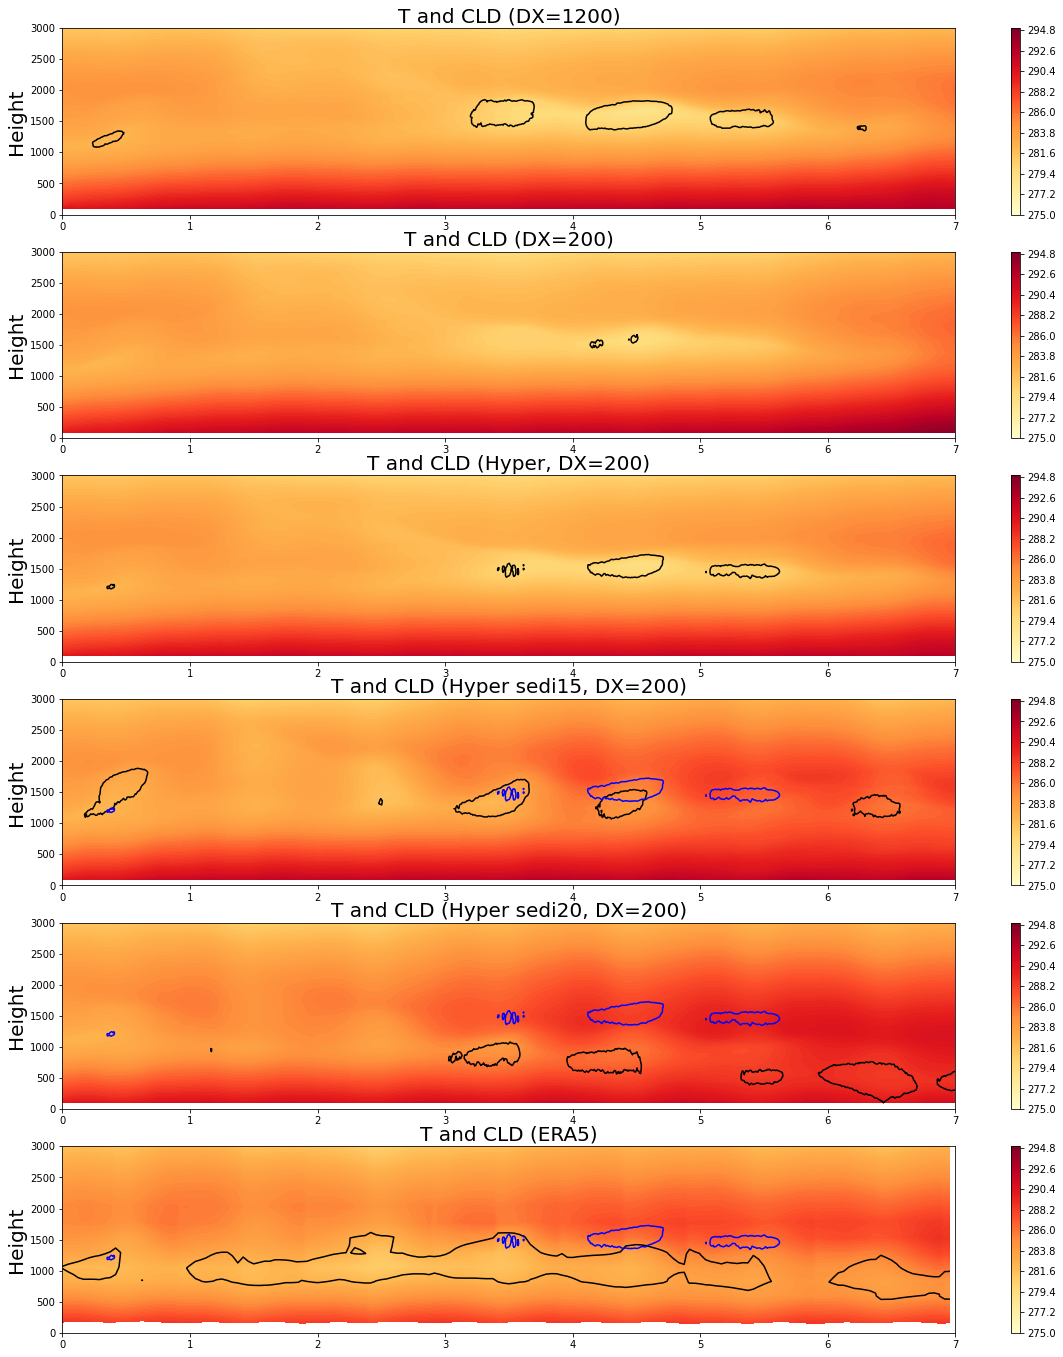

In [62]:
#  For SPCTRL and UPCTRL, both finished 5 day simulation
fig, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(nrows=6, ncols=1, figsize=(20, 24))
varmin = [275]
varmax = [295]
varinter = [101]
vardmin = [-4]
vardmax = [4]
vardinter = [101]
num1 = 1009
num2 = 1009
time0 = np.linspace(0, num1, num1)
time2 = np.linspace(0, num2, num2)
time1 = np.zeros([1009,125])
for it in range(125):
    time1[:,it] = time0
time = np.transpose(time1)
levels = np.linspace(varmin[0], varmax[0], varinter[0])
levels2 = np.linspace(vardmin[0], vardmax[0], vardinter[0])

cf = ax1.contourf(time/144,Z3_crossSPPeruvian,T_crossSPPeruvian,200, cmap="YlOrRd", levels=levels)
cf01 = ax1.contour(time/144,Z3_crossSPPeruvian,cld_crossSPPeruvian,200,colors='k', levels=[0.2], linestyles='-')
#cf0002 = ax1.contour(time/144,Z3p,cld_cross1,200, colors='k', levels=[0.8], linestyles=':')
cb = fig.colorbar(cf, ax=ax1)
ax1.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("T and CLD (DX=1200)")
tx = ax1.set_title(titlestring, fontsize=20)
#ax1.set_xlabel('Day', fontsize=20)
ax1.set_ylabel('Height', fontsize=20)

cf2 = ax2.contourf(time/144,Z3_crossUPPeruvian,T_crossUPPeruvian,200, cmap="YlOrRd", levels=levels)
cf02 = ax2.contour(time/144,Z3_crossUPPeruvian,cld_crossUPPeruvian,200,colors='k', levels=[0.2], linestyles='-')
cb2 = fig.colorbar(cf2, ax=ax2)
ax2.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("T and CLD (DX=200)")
tx = ax2.set_title(titlestring, fontsize=20)
#ax2.set_xlabel('Day', fontsize=20)
ax2.set_ylabel('Height', fontsize=20)

cf3 = ax3.contourf(time/144,Z3_crossUPhyPeruvian,T_crossUPhyPeruvian,200, cmap="YlOrRd", levels=levels)
cf03 = ax3.contour(time/144,Z3_crossUPhyPeruvian,cld_crossUPhyPeruvian,200,colors='k', levels=[0.2], linestyles='-')
cb3 = fig.colorbar(cf3, ax=ax3)
ax3.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("T and CLD (Hyper, DX=200)")
tx = ax3.set_title(titlestring, fontsize=20)
#ax2.set_xlabel('Day', fontsize=20)
ax3.set_ylabel('Height', fontsize=20)

cf4 = ax4.contourf(time/144,Z3_crossUPhysedi15Peruvian,T_crossUPhysedi15Peruvian,200, cmap="YlOrRd", levels=levels)
cf04 = ax4.contour(time/144,Z3_crossUPhysedi15Peruvian,cld_crossUPhysedi15Peruvian,200,colors='k', levels=[0.2], linestyles='-')
cf042 = ax4.contour(time/144,Z3_crossUPhyPeruvian,cld_crossUPhyPeruvian,200,colors='b', levels=[0.2], linestyles='-')
cb4 = fig.colorbar(cf4, ax=ax4)
ax4.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("T and CLD (Hyper sedi15, DX=200)")
tx = ax4.set_title(titlestring, fontsize=20)
#ax2.set_xlabel('Day', fontsize=20)
ax4.set_ylabel('Height', fontsize=20)

cf5 = ax5.contourf(time/144,Z3_crossUPhysedi20Peruvian,T_crossUPhysedi20Peruvian,200, cmap="YlOrRd", levels=levels)
cf05 = ax5.contour(time/144,Z3_crossUPhysedi20Peruvian,cld_crossUPhysedi20Peruvian,200,colors='k', levels=[0.2], linestyles='-')
cf052 = ax5.contour(time/144,Z3_crossUPhyPeruvian,cld_crossUPhyPeruvian,200,colors='b', levels=[0.2], linestyles='-')
cb5 = fig.colorbar(cf5, ax=ax5)
ax5.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("T and CLD (Hyper sedi20, DX=200)")
tx = ax5.set_title(titlestring, fontsize=20)
#ax2.set_xlabel('Day', fontsize=20)
ax5.set_ylabel('Height', fontsize=20)

cf6 = ax6.contourf(ERA_Time,ERA5_zPeruvian/9.8,ERA5_tPeruvian,200, cmap="YlOrRd", levels=levels)
cf06 = ax6.contour(ERA_Time,ERA5_zPeruvian/9.8,ERA5_ccPeruvian,200,colors='k', levels=[0.2], linestyles='-')
cf062 = ax6.contour(time/144,Z3_crossUPhyPeruvian,cld_crossUPhyPeruvian,200,colors='b', levels=[0.2], linestyles='-')
cb6 = fig.colorbar(cf6, ax=ax6)
ax6.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("T and CLD (ERA5)")
tx = ax6.set_title(titlestring, fontsize=20)
#ax2.set_xlabel('Day', fontsize=20)
ax6.set_ylabel('Height', fontsize=20)

plt.savefig('Peruvian_Time_Height_Model_ERA5.png')

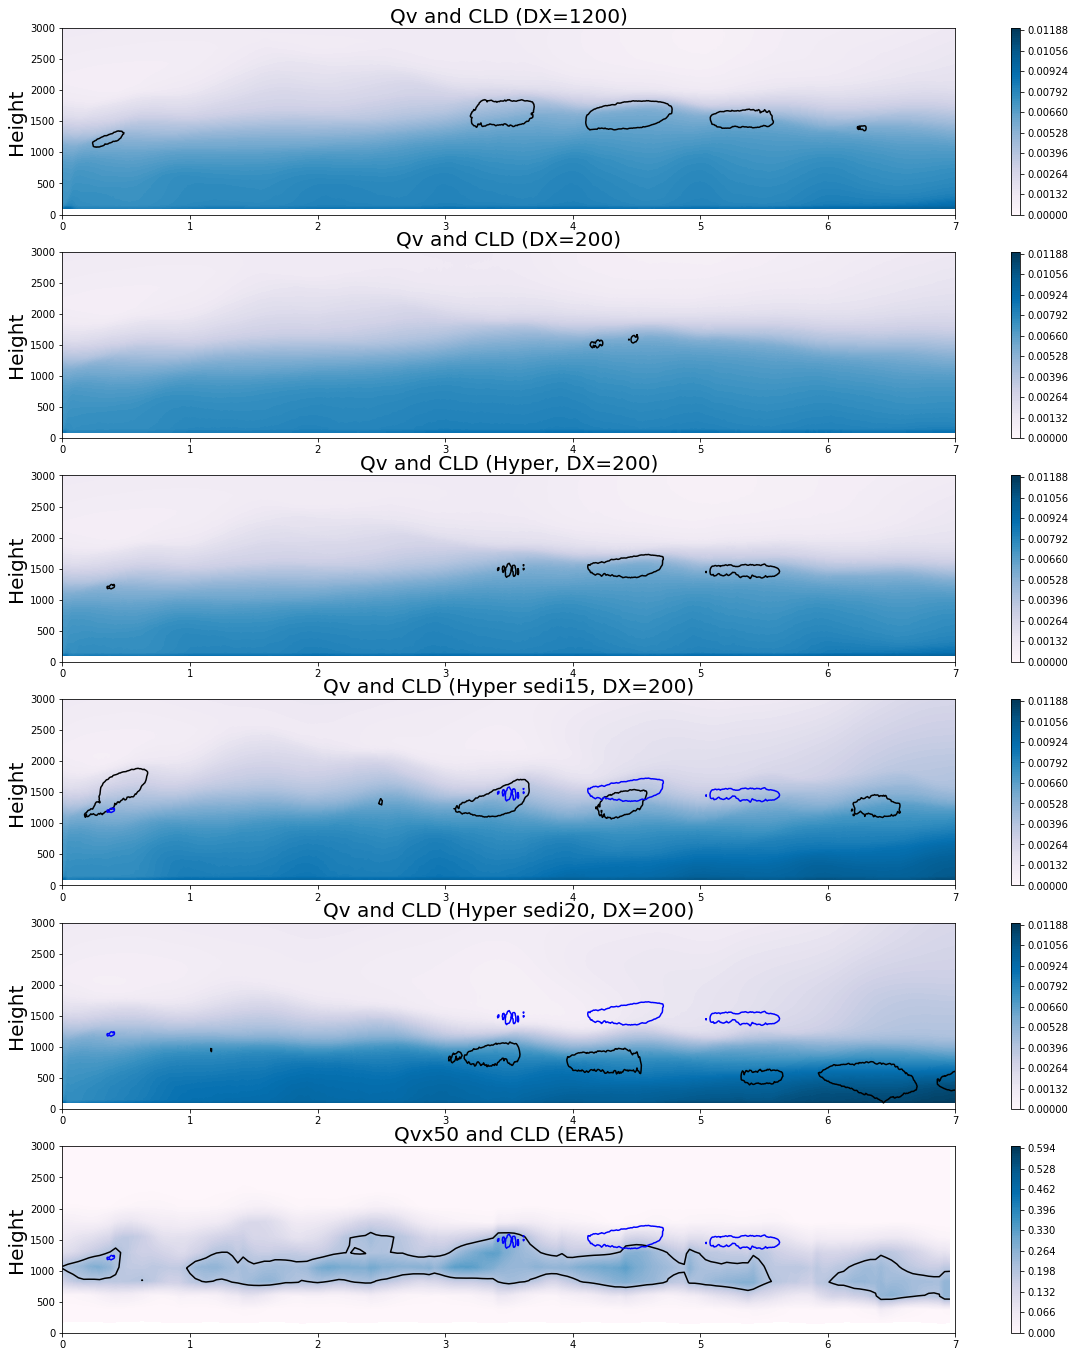

In [87]:
#  For SPCTRL and UPCTRL, both finished 5 day simulation
fig, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(nrows=6, ncols=1, figsize=(20, 24))
varmin = [0]
varmax = [0.012]
varinter = [101]
vardmin = [-4]
vardmax = [4]
vardinter = [101]
num1 = 1009
num2 = 1009
time0 = np.linspace(0, num1, num1)
time2 = np.linspace(0, num2, num2)
time1 = np.zeros([1009,125])
for it in range(125):
    time1[:,it] = time0
time = np.transpose(time1)
levels = np.linspace(varmin[0], varmax[0], varinter[0])
levels2 = np.linspace(vardmin[0], vardmax[0], vardinter[0])

cf = ax1.contourf(time/144,Z3_crossSPPeruvian,Q_crossSPPeruvian,200, cmap="PuBu", levels=levels)
cf01 = ax1.contour(time/144,Z3_crossSPPeruvian,cld_crossSPPeruvian,200,colors='k', levels=[0.2], linestyles='-')
#cf0002 = ax1.contour(time/144,Z3p,cld_cross1,200, colors='k', levels=[0.8], linestyles=':')
cb = fig.colorbar(cf, ax=ax1)
ax1.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("Qv and CLD (DX=1200)")
tx = ax1.set_title(titlestring, fontsize=20)
#ax1.seQ_xlabel('Day', fontsize=20)
ax1.set_ylabel('Height', fontsize=20)

cf2 = ax2.contourf(time/144,Z3_crossUPPeruvian,Q_crossUPPeruvian,200, cmap="PuBu", levels=levels)
cf02 = ax2.contour(time/144,Z3_crossUPPeruvian,cld_crossUPPeruvian,200,colors='k', levels=[0.2], linestyles='-')
cb2 = fig.colorbar(cf2, ax=ax2)
ax2.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("Qv and CLD (DX=200)")
tx = ax2.set_title(titlestring, fontsize=20)
#ax2.seQ_xlabel('Day', fontsize=20)
ax2.set_ylabel('Height', fontsize=20)

cf3 = ax3.contourf(time/144,Z3_crossUPhyPeruvian,Q_crossUPhyPeruvian,200, cmap="PuBu", levels=levels)
cf03 = ax3.contour(time/144,Z3_crossUPhyPeruvian,cld_crossUPhyPeruvian,200,colors='k', levels=[0.2], linestyles='-')
cb3 = fig.colorbar(cf3, ax=ax3)
ax3.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("Qv and CLD (Hyper, DX=200)")
tx = ax3.set_title(titlestring, fontsize=20)
#ax2.seQ_xlabel('Day', fontsize=20)
ax3.set_ylabel('Height', fontsize=20)

cf4 = ax4.contourf(time/144,Z3_crossUPhysedi15Peruvian,Q_crossUPhysedi15Peruvian,200, cmap="PuBu", levels=levels)
cf04 = ax4.contour(time/144,Z3_crossUPhysedi15Peruvian,cld_crossUPhysedi15Peruvian,200,colors='k', levels=[0.2], linestyles='-')
cf042 = ax4.contour(time/144,Z3_crossUPhyPeruvian,cld_crossUPhyPeruvian,200,colors='b', levels=[0.2], linestyles='-')
cb4 = fig.colorbar(cf4, ax=ax4)
ax4.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("Qv and CLD (Hyper sedi15, DX=200)")
tx = ax4.set_title(titlestring, fontsize=20)
#ax2.seQ_xlabel('Day', fontsize=20)
ax4.set_ylabel('Height', fontsize=20)

cf5 = ax5.contourf(time/144,Z3_crossUPhysedi20Peruvian,Q_crossUPhysedi20Peruvian,200, cmap="PuBu", levels=levels)
cf05 = ax5.contour(time/144,Z3_crossUPhysedi20Peruvian,cld_crossUPhysedi20Peruvian,200,colors='k', levels=[0.2], linestyles='-')
cf052 = ax5.contour(time/144,Z3_crossUPhyPeruvian,cld_crossUPhyPeruvian,200,colors='b', levels=[0.2], linestyles='-')
cb5 = fig.colorbar(cf5, ax=ax5)
ax5.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("Qv and CLD (Hyper sedi20, DX=200)")
tx = ax5.set_title(titlestring, fontsize=20)
#ax2.seQ_xlabel('Day', fontsize=20)
ax5.set_ylabel('Height', fontsize=20)

cf6 = ax6.contourf(ERA_Time,ERA5_zPeruvian/9.8,ERA5_qPeruvian,200, cmap="PuBu", levels=levels*50)
cf06 = ax6.contour(ERA_Time,ERA5_zPeruvian/9.8,ERA5_ccPeruvian,200,colors='k', levels=[0.2], linestyles='-')
cf062 = ax6.contour(time/144,Z3_crossUPhyPeruvian,cld_crossUPhyPeruvian,200,colors='b', levels=[0.2], linestyles='-')
cb6 = fig.colorbar(cf6, ax=ax6)
ax6.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("Qvx50 and CLD (ERA5)")
tx = ax6.set_title(titlestring, fontsize=20)
#ax2.seQ_xlabel('Day', fontsize=20)
ax6.set_ylabel('Height', fontsize=20)

plt.savefig('Peruvian_Time_HeighQv_Model_ERA5.png')

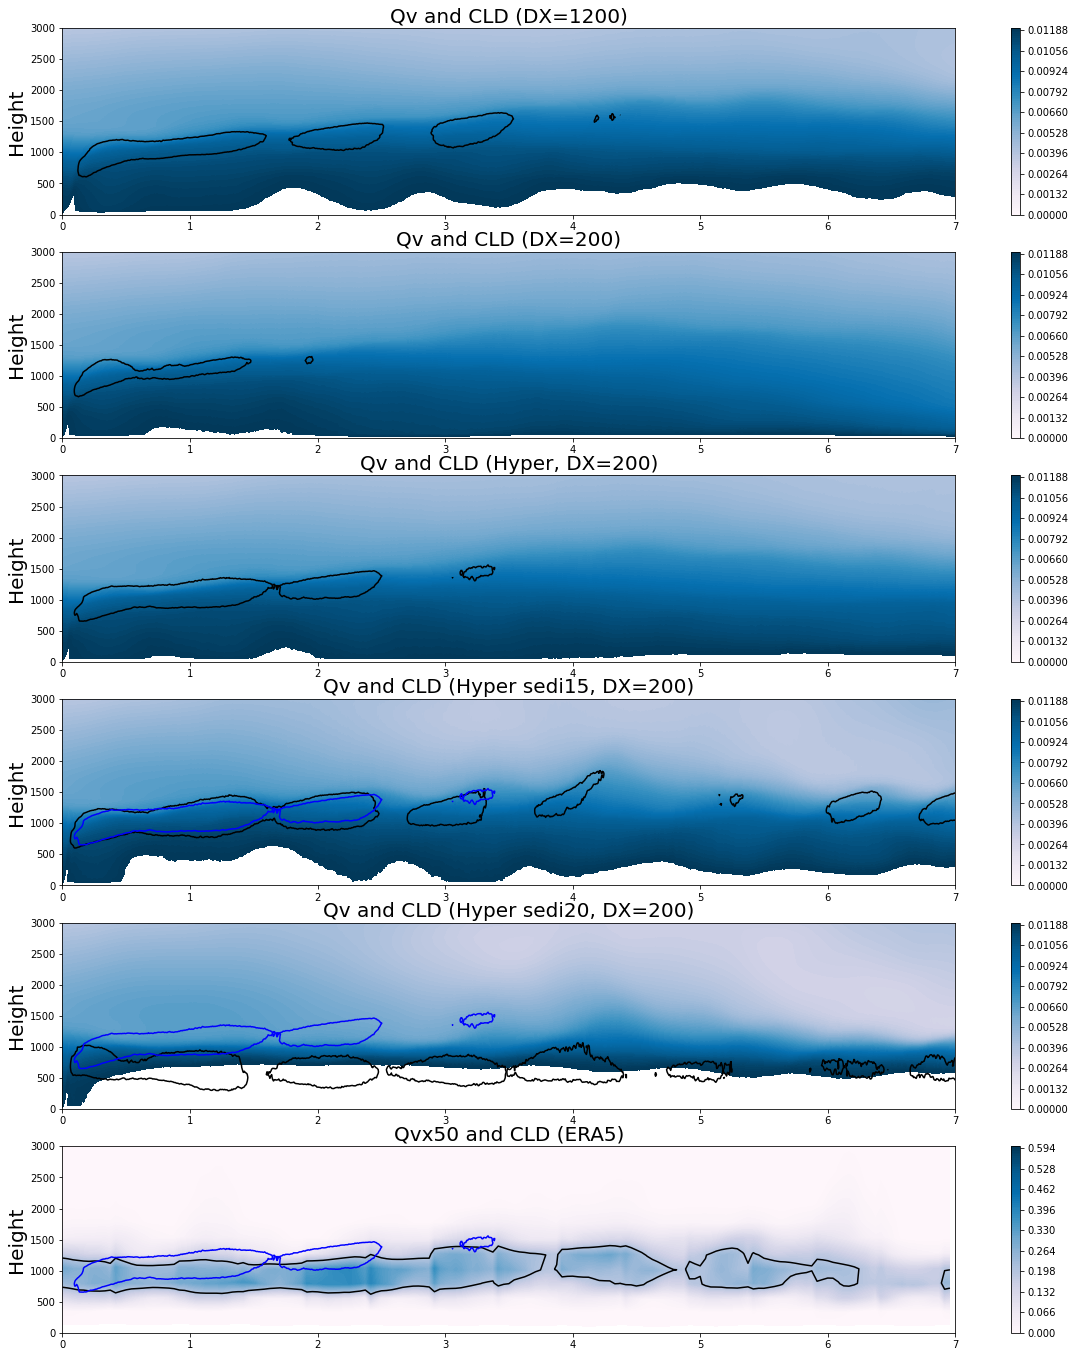

In [88]:
#  For SPCTRL and UPCTRL, both finished 5 day simulation
fig, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(nrows=6, ncols=1, figsize=(20, 24))
varmin = [0]
varmax = [0.012]
varinter = [101]
vardmin = [-4]
vardmax = [4]
vardinter = [101]
num1 = 1009
num2 = 1009
time0 = np.linspace(0, num1, num1)
time2 = np.linspace(0, num2, num2)
time1 = np.zeros([1009,125])
for it in range(125):
    time1[:,it] = time0
time = np.transpose(time1)
levels = np.linspace(varmin[0], varmax[0], varinter[0])
levels2 = np.linspace(vardmin[0], vardmax[0], vardinter[0])

cf = ax1.contourf(time/144,Z3_crossSPNamibian,Q_crossSPNamibian,200, cmap="PuBu", levels=levels)
cf01 = ax1.contour(time/144,Z3_crossSPNamibian,cld_crossSPNamibian,200,colors='k', levels=[0.2], linestyles='-')
#cf0002 = ax1.contour(time/144,Z3p,cld_cross1,200, colors='k', levels=[0.8], linestyles=':')
cb = fig.colorbar(cf, ax=ax1)
ax1.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("Qv and CLD (DX=1200)")
tx = ax1.set_title(titlestring, fontsize=20)
#ax1.seQ_xlabel('Day', fontsize=20)
ax1.set_ylabel('Height', fontsize=20)

cf2 = ax2.contourf(time/144,Z3_crossUPNamibian,Q_crossUPNamibian,200, cmap="PuBu", levels=levels)
cf02 = ax2.contour(time/144,Z3_crossUPNamibian,cld_crossUPNamibian,200,colors='k', levels=[0.2], linestyles='-')
cb2 = fig.colorbar(cf2, ax=ax2)
ax2.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("Qv and CLD (DX=200)")
tx = ax2.set_title(titlestring, fontsize=20)
#ax2.seQ_xlabel('Day', fontsize=20)
ax2.set_ylabel('Height', fontsize=20)

cf3 = ax3.contourf(time/144,Z3_crossUPhyNamibian,Q_crossUPhyNamibian,200, cmap="PuBu", levels=levels)
cf03 = ax3.contour(time/144,Z3_crossUPhyNamibian,cld_crossUPhyNamibian,200,colors='k', levels=[0.2], linestyles='-')
cb3 = fig.colorbar(cf3, ax=ax3)
ax3.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("Qv and CLD (Hyper, DX=200)")
tx = ax3.set_title(titlestring, fontsize=20)
#ax2.seQ_xlabel('Day', fontsize=20)
ax3.set_ylabel('Height', fontsize=20)

cf4 = ax4.contourf(time/144,Z3_crossUPhysedi15Namibian,Q_crossUPhysedi15Namibian,200, cmap="PuBu", levels=levels)
cf04 = ax4.contour(time/144,Z3_crossUPhysedi15Namibian,cld_crossUPhysedi15Namibian,200,colors='k', levels=[0.2], linestyles='-')
cf042 = ax4.contour(time/144,Z3_crossUPhyNamibian,cld_crossUPhyNamibian,200,colors='b', levels=[0.2], linestyles='-')
cb4 = fig.colorbar(cf4, ax=ax4)
ax4.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("Qv and CLD (Hyper sedi15, DX=200)")
tx = ax4.set_title(titlestring, fontsize=20)
#ax2.seQ_xlabel('Day', fontsize=20)
ax4.set_ylabel('Height', fontsize=20)

cf5 = ax5.contourf(time/144,Z3_crossUPhysedi20Namibian,Q_crossUPhysedi20Namibian,200, cmap="PuBu", levels=levels)
cf05 = ax5.contour(time/144,Z3_crossUPhysedi20Namibian,cld_crossUPhysedi20Namibian,200,colors='k', levels=[0.2], linestyles='-')
cf052 = ax5.contour(time/144,Z3_crossUPhyNamibian,cld_crossUPhyNamibian,200,colors='b', levels=[0.2], linestyles='-')
cb5 = fig.colorbar(cf5, ax=ax5)
ax5.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("Qv and CLD (Hyper sedi20, DX=200)")
tx = ax5.set_title(titlestring, fontsize=20)
#ax2.seQ_xlabel('Day', fontsize=20)
ax5.set_ylabel('Height', fontsize=20)

cf6 = ax6.contourf(ERA_Time,ERA5_zNamibian/9.8,ERA5_qNamibian,200, cmap="PuBu", levels=levels*50)
cf06 = ax6.contour(ERA_Time,ERA5_zNamibian/9.8,ERA5_ccNamibian,200,colors='k', levels=[0.2], linestyles='-')
cf062 = ax6.contour(time/144,Z3_crossUPhyNamibian,cld_crossUPhyNamibian,200,colors='b', levels=[0.2], linestyles='-')
cb6 = fig.colorbar(cf6, ax=ax6)
ax6.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("Qvx50 and CLD (ERA5)")
tx = ax6.set_title(titlestring, fontsize=20)
#ax2.seQ_xlabel('Day', fontsize=20)
ax6.set_ylabel('Height', fontsize=20)

plt.savefig('Namibian_Time_HeighQv_Model_ERA5.png')

# Namibian

In [63]:
spww_SPNamibian = np.zeros([1009,125])
spww_UPNamibian = np.zeros([1009,125])
spww_UPhyNamibian = np.zeros([1009,125])
spww_UPhysedi20Namibian = np.zeros([1009,125])
spww_UPhysedi15Namibian = np.zeros([1009,125])
Z3_SPNamibian = np.zeros([1009,125])
Z3_UPNamibian = np.zeros([1009,125])
Z3_UPhyNamibian = np.zeros([1009,125])
Z3_UPhysedi20Namibian = np.zeros([1009,125])
Z3_UPhysedi15Namibian = np.zeros([1009,125])
pttend_SPNamibian = np.zeros([1009,125])
pttend_UPNamibian = np.zeros([1009,125])
pttend_UPhyNamibian = np.zeros([1009,125])
pttend_UPhysedi20Namibian = np.zeros([1009,125])
pttend_UPhysedi15Namibian = np.zeros([1009,125])
cld_SPNamibian = np.zeros([1009,125])
cld_UPNamibian = np.zeros([1009,125])
cld_UPhyNamibian = np.zeros([1009,125])
cld_UPhysedi20Namibian = np.zeros([1009,125])
cld_UPhysedi15Namibian = np.zeros([1009,125])
T_SPNamibian = np.zeros([1009,125])
T_UPNamibian = np.zeros([1009,125])
T_UPhyNamibian = np.zeros([1009,125])
T_UPhysedi20Namibian = np.zeros([1009,125])
T_UPhysedi15Namibian = np.zeros([1009,125])
Q_SPNamibian = np.zeros([1009,125])
Q_UPNamibian = np.zeros([1009,125])
Q_UPhyNamibian = np.zeros([1009,125])
Q_UPhysedi20Namibian = np.zeros([1009,125])
Q_UPhysedi15Namibian = np.zeros([1009,125])
for it in range(1009):
    count = 0
    for il in range(len(ind_Namibian)):
        spww_SPNamibian[it,:] = spww_SPNamibian[it,:] + SPWWSP[it,:,ind_Namibian[il]]
        spww_UPNamibian[it,:] = spww_UPNamibian[it,:] + SPWWUP[it,:,ind_Namibian[il]]
        spww_UPhyNamibian[it,:] = spww_UPhyNamibian[it,:] + SPWWUPhy[it,:,ind_Namibian[il]]
        spww_UPhysedi15Namibian[it,:] = spww_UPhysedi15Namibian[it,:] + SPWWUPhysedi15[it,:,ind_Namibian[il]]
        spww_UPhysedi20Namibian[it,:] = spww_UPhysedi20Namibian[it,:] + SPWWUPhysedi20[it,:,ind_Namibian[il]]
        Z3_SPNamibian[it,:] = Z3_SPNamibian[it,:] + Z3SP[it,:,ind_Namibian[il]]
        Z3_UPNamibian[it,:] = Z3_UPNamibian[it,:] + Z3UP[it,:,ind_Namibian[il]]
        Z3_UPhyNamibian[it,:] = Z3_UPhyNamibian[it,:] + Z3UPhy[it,:,ind_Namibian[il]]
        Z3_UPhysedi15Namibian[it,:] = Z3_UPhysedi15Namibian[it,:] + Z3UPhysedi15[it,:,ind_Namibian[il]]
        Z3_UPhysedi20Namibian[it,:] = Z3_UPhysedi20Namibian[it,:] + Z3UPhysedi20[it,:,ind_Namibian[il]]
        T_SPNamibian[it,:] = T_SPNamibian[it,:] + T_SP[it,:,ind_Namibian[il]]
        T_UPNamibian[it,:] = T_UPNamibian[it,:] + T_UP[it,:,ind_Namibian[il]]
        T_UPhyNamibian[it,:] = T_UPhyNamibian[it,:] + T_UPhy[it,:,ind_Namibian[il]]
        T_UPhysedi15Namibian[it,:] = T_UPhysedi15Namibian[it,:] + T_UPhysedi15[it,:,ind_Namibian[il]]
        T_UPhysedi20Namibian[it,:] = T_UPhysedi20Namibian[it,:] + T_UPhysedi20[it,:,ind_Namibian[il]]
        Q_SPNamibian[it,:] = Q_SPNamibian[it,:] + Q_SP[it,:,ind_Namibian[il]]
        Q_UPNamibian[it,:] = Q_UPNamibian[it,:] + Q_UP[it,:,ind_Namibian[il]]
        Q_UPhyNamibian[it,:] = Q_UPhyNamibian[it,:] + Q_UPhy[it,:,ind_Namibian[il]]
        Q_UPhysedi15Namibian[it,:] = Q_UPhysedi15Namibian[it,:] + Q_UPhysedi15[it,:,ind_Namibian[il]]
        Q_UPhysedi20Namibian[it,:] = Q_UPhysedi20Namibian[it,:] + Q_UPhysedi20[it,:,ind_Namibian[il]]
        pttend_SPNamibian[it,:] = pttend_SPNamibian[it,:] + PTTEND_SP[it,:,ind_Namibian[il]]
        pttend_UPNamibian[it,:] = pttend_UPNamibian[it,:] + PTTEND_UP[it,:,ind_Namibian[il]]
        pttend_UPhyNamibian[it,:] = pttend_UPhyNamibian[it,:] + PTTEND_UPhy[it,:,ind_Namibian[il]]
        pttend_UPhysedi15Namibian[it,:] = pttend_UPhysedi15Namibian[it,:] + PTTEND_UPhysedi15[it,:,ind_Namibian[il]]
        pttend_UPhysedi20Namibian[it,:] = pttend_UPhysedi20Namibian[it,:] + PTTEND_UPhysedi20[it,:,ind_Namibian[il]]
        cld_SPNamibian[it,:] = cld_SPNamibian[it,:] + CLOUD_SP[it,:,ind_Namibian[il]]
        cld_UPNamibian[it,:] = cld_UPNamibian[it,:] + CLOUD_UP[it,:,ind_Namibian[il]]
        cld_UPhyNamibian[it,:] = cld_UPhyNamibian[it,:] + CLOUD_UPhy[it,:,ind_Namibian[il]]
        cld_UPhysedi15Namibian[it,:] = cld_UPhysedi15Namibian[it,:] + CLOUD_UPhysedi15[it,:,ind_Namibian[il]]
        cld_UPhysedi20Namibian[it,:] = cld_UPhysedi20Namibian[it,:] + CLOUD_UPhysedi20[it,:,ind_Namibian[il]]
        count = count + 1
            
    spww_SPNamibian[it,:] = spww_SPNamibian[it,:] /count
    spww_UPNamibian[it,:] = spww_UPNamibian[it,:]  /count
    spww_UPhyNamibian[it,:] = spww_UPhyNamibian[it,:] /count
    spww_UPhysedi15Namibian[it,:] = spww_UPhysedi15Namibian[it,:] /count
    spww_UPhysedi20Namibian[it,:] = spww_UPhysedi20Namibian[it,:] /count
    Z3_SPNamibian[it,:] = Z3_SPNamibian[it,:] /count
    Z3_UPNamibian[it,:] = Z3_UPNamibian[it,:]  /count
    Z3_UPhyNamibian[it,:] = Z3_UPhyNamibian[it,:] /count
    Z3_UPhysedi15Namibian[it,:] = Z3_UPhysedi15Namibian[it,:] /count
    Z3_UPhysedi20Namibian[it,:] = Z3_UPhysedi20Namibian[it,:] /count
    T_SPNamibian[it,:] = T_SPNamibian[it,:] /count
    T_UPNamibian[it,:] = T_UPNamibian[it,:]  /count
    T_UPhyNamibian[it,:] = T_UPhyNamibian[it,:] /count
    T_UPhysedi15Namibian[it,:] = T_UPhysedi15Namibian[it,:] /count
    T_UPhysedi20Namibian[it,:] = T_UPhysedi20Namibian[it,:] /count
    Q_SPNamibian[it,:] = Q_SPNamibian[it,:] /count
    Q_UPNamibian[it,:] = Q_UPNamibian[it,:]  /count
    Q_UPhyNamibian[it,:] = Q_UPhyNamibian[it,:] /count
    Q_UPhysedi15Namibian[it,:] = Q_UPhysedi15Namibian[it,:] /count
    Q_UPhysedi20Namibian[it,:] = Q_UPhysedi20Namibian[it,:] /count
    pttend_SPNamibian[it,:] = pttend_SPNamibian[it,:] /count
    pttend_UPNamibian[it,:] = pttend_UPNamibian[it,:]  /count
    pttend_UPhyNamibian[it,:] = pttend_UPhyNamibian[it,:] /count
    pttend_UPhysedi15Namibian[it,:] = pttend_UPhysedi15Namibian[it,:] /count
    pttend_UPhysedi20Namibian[it,:] = pttend_UPhysedi20Namibian[it,:] /count
    cld_SPNamibian[it,:] = cld_SPNamibian[it,:] /count
    cld_UPNamibian[it,:] = cld_UPNamibian[it,:]  /count
    cld_UPhyNamibian[it,:] = cld_UPhyNamibian[it,:] /count
    cld_UPhysedi15Namibian[it,:] = cld_UPhysedi15Namibian[it,:] /count
    cld_UPhysedi20Namibian[it,:] = cld_UPhysedi20Namibian[it,:] /count
    
spww_crossSPNamibian = np.transpose(spww_SPNamibian)
spww_crossUPNamibian = np.transpose(spww_UPNamibian)
spww_crossUPhyNamibian = np.transpose(spww_UPhyNamibian)
spww_crossUPhysedi15Namibian = np.transpose(spww_UPhysedi15Namibian)
spww_crossUPhysedi20Namibian = np.transpose(spww_UPhysedi20Namibian)
Z3_crossSPNamibian = np.transpose(Z3_SPNamibian)
Z3_crossUPNamibian = np.transpose(Z3_UPNamibian)
Z3_crossUPhyNamibian = np.transpose(Z3_UPhyNamibian)
Z3_crossUPhysedi15Namibian = np.transpose(Z3_UPhysedi15Namibian)
Z3_crossUPhysedi20Namibian = np.transpose(Z3_UPhysedi20Namibian)
T_crossSPNamibian = np.transpose(T_SPNamibian)
T_crossUPNamibian = np.transpose(T_UPNamibian)
T_crossUPhyNamibian = np.transpose(T_UPhyNamibian)
T_crossUPhysedi15Namibian = np.transpose(T_UPhysedi15Namibian)
T_crossUPhysedi20Namibian = np.transpose(T_UPhysedi20Namibian)
Q_crossSPNamibian = np.transpose(Q_SPNamibian)
Q_crossUPNamibian = np.transpose(Q_UPNamibian)
Q_crossUPhyNamibian = np.transpose(Q_UPhyNamibian)
Q_crossUPhysedi15Namibian = np.transpose(Q_UPhysedi15Namibian)
Q_crossUPhysedi20Namibian = np.transpose(Q_UPhysedi20Namibian)
pttend_crossSPNamibian = np.transpose(pttend_SPNamibian)
pttend_crossUPNamibian = np.transpose(pttend_UPNamibian)
pttend_crossUPhyNamibian = np.transpose(pttend_UPhyNamibian)
pttend_crossUPhysedi15Namibian = np.transpose(pttend_UPhysedi15Namibian)
pttend_crossUPhysedi20Namibian = np.transpose(pttend_UPhysedi20Namibian)
cld_crossSPNamibian = np.transpose(cld_SPNamibian)
cld_crossUPNamibian = np.transpose(cld_UPNamibian)
cld_crossUPhyNamibian = np.transpose(cld_UPhyNamibian)
cld_crossUPhysedi15Namibian = np.transpose(cld_UPhysedi15Namibian)
cld_crossUPhysedi20Namibian = np.transpose(cld_UPhysedi20Namibian)

In [85]:
countt = 0
temp3d = np.zeros([16,721,1440])
temp3d2 = np.zeros([16,721,1440])
temp3d3 = np.zeros([16,721,1440])
temp3d4 = np.zeros([16,721,1440])
temp = np.zeros([721,1440])
temp2 = np.zeros([721,1440])
temp3 = np.zeros([721,1440])
temp4 = np.zeros([721,1440])
ERA5_tNamibian = np.zeros([24*7,16])
ERA5_qNamibian = np.zeros([24*7,16])
ERA5_zNamibian = np.zeros([24*7,16])
ERA5_ccNamibian = np.zeros([24*7,16])
ERA_Time = np.zeros([24*7,16])
for iday in range(7):
    print(iday)
    for ihour in range(24):
        temp3d[:,:,:] = ERA5_thourly[countt,:,:]
        temp3d2[:,:,:] = ERA5_zhourly[countt,:,:]
        temp3d3[:,:,:] = ERA5_cchourly[countt,:,:]
        temp3d4[:,:,:] = ERA5_qhourly[countt,:,:]
        for iz in range(16):
            temp[:,:] = temp3d[iz,:,:]
            temp2[:,:] = temp3d2[iz,:,:]
            temp3[:,:] = temp3d3[iz,:,:]
            temp4[:,:] = temp3d3[iz,:,:]
            temp1d = temp.flatten()
            temp1d2 = temp2.flatten()
            temp1d3 = temp3.flatten()
            temp1d4 = temp4.flatten()
            counttt3 = 0
            for il in range(len(ind_Namibian_ERA5)):
                ERA5_tNamibian[countt,iz] = ERA5_tNamibian[countt,iz] + temp1d[ind_Namibian_ERA5[il]]
                ERA5_zNamibian[countt,iz] = ERA5_zNamibian[countt,iz] + temp1d2[ind_Namibian_ERA5[il]]
                ERA5_ccNamibian[countt,iz] = ERA5_ccNamibian[countt,iz] + temp1d3[ind_Namibian_ERA5[il]]
                ERA5_qNamibian[countt,iz] = ERA5_qNamibian[countt,iz] + temp1d4[ind_Namibian_ERA5[il]]
                counttt3 = counttt3 + 1        
            ERA5_tNamibian[countt,iz] = ERA5_tNamibian[countt,iz]/counttt3
            ERA5_zNamibian[countt,iz] = ERA5_zNamibian[countt,iz]/counttt3
            ERA5_ccNamibian[countt,iz] = ERA5_ccNamibian[countt,iz]/counttt3
            ERA5_qNamibian[countt,iz] = ERA5_qNamibian[countt,iz]/counttt3
            ERA_Time[countt,iz] = iday + ihour/24
        countt = countt+1

0
1
2
3
4
5
6


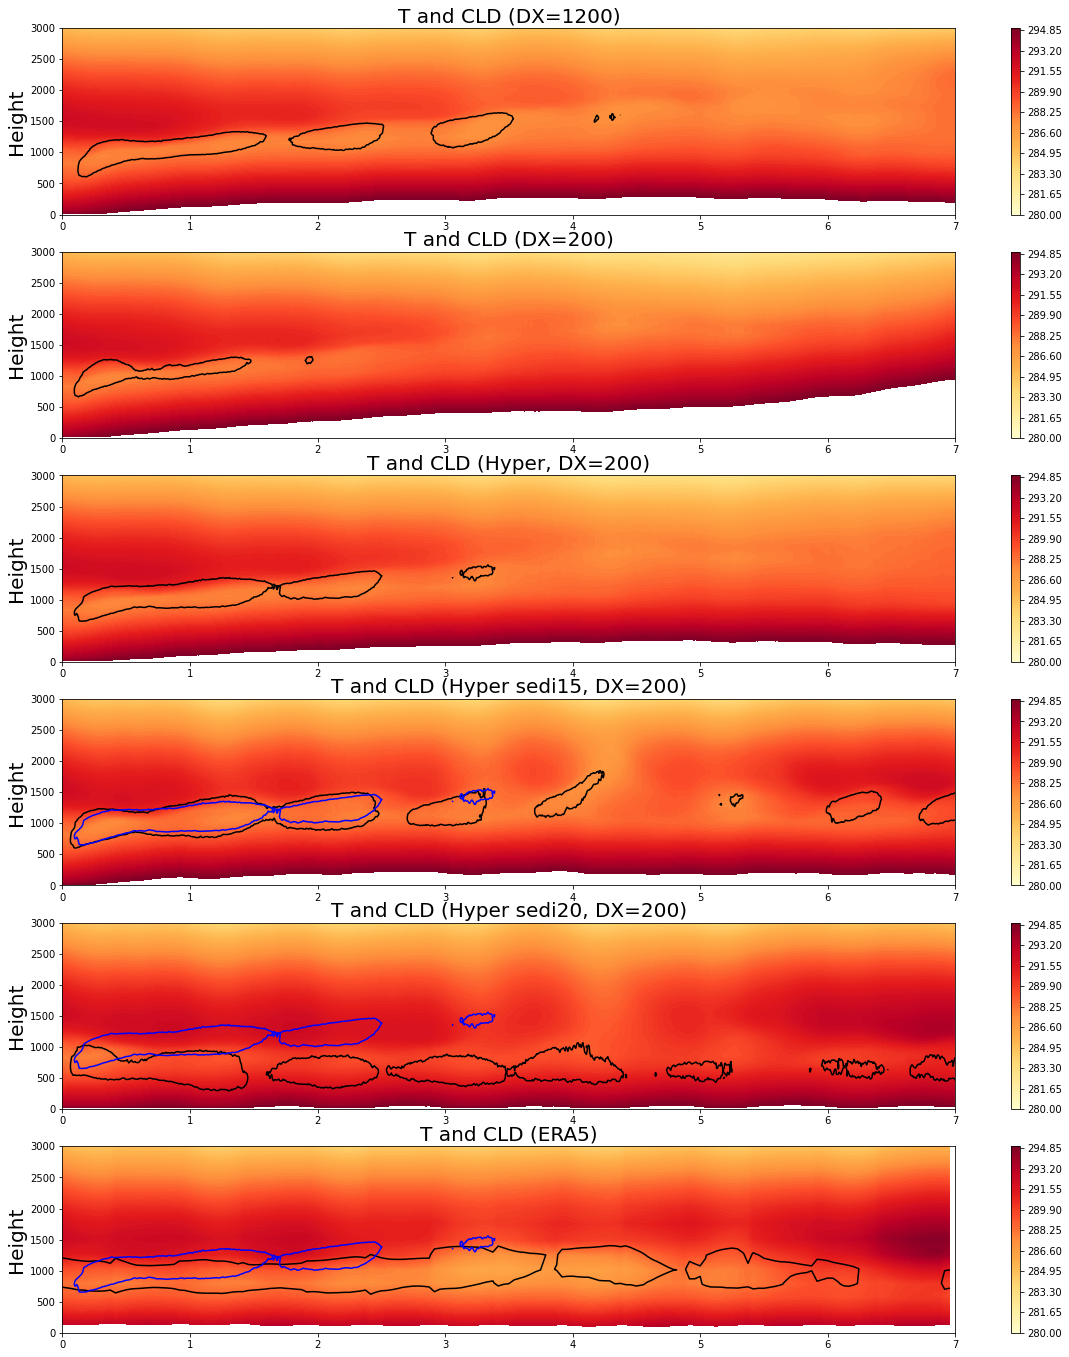

In [66]:
#  For SPCTRL and UPCTRL, both finished 5 day simulation
fig, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(nrows=6, ncols=1, figsize=(20, 24))
varmin = [280]
varmax = [295]
varinter = [101]
vardmin = [-4]
vardmax = [4]
vardinter = [101]
num1 = 1009
num2 = 1009
time0 = np.linspace(0, num1, num1)
time2 = np.linspace(0, num2, num2)
time1 = np.zeros([1009,125])
for it in range(125):
    time1[:,it] = time0
time = np.transpose(time1)
levels = np.linspace(varmin[0], varmax[0], varinter[0])
levels2 = np.linspace(vardmin[0], vardmax[0], vardinter[0])

cf = ax1.contourf(time/144,Z3_crossSPNamibian,T_crossSPNamibian,200, cmap="YlOrRd", levels=levels)
cf01 = ax1.contour(time/144,Z3_crossSPNamibian,cld_crossSPNamibian,200,colors='k', levels=[0.2], linestyles='-')
#cf0002 = ax1.contour(time/144,Z3p,cld_cross1,200, colors='k', levels=[0.8], linestyles=':')
cb = fig.colorbar(cf, ax=ax1)
ax1.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("T and CLD (DX=1200)")
tx = ax1.set_title(titlestring, fontsize=20)
#ax1.set_xlabel('Day', fontsize=20)
ax1.set_ylabel('Height', fontsize=20)

cf2 = ax2.contourf(time/144,Z3_crossUPNamibian,T_crossUPNamibian,200, cmap="YlOrRd", levels=levels)
cf02 = ax2.contour(time/144,Z3_crossUPNamibian,cld_crossUPNamibian,200,colors='k', levels=[0.2], linestyles='-')
cb2 = fig.colorbar(cf2, ax=ax2)
ax2.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("T and CLD (DX=200)")
tx = ax2.set_title(titlestring, fontsize=20)
#ax2.set_xlabel('Day', fontsize=20)
ax2.set_ylabel('Height', fontsize=20)

cf3 = ax3.contourf(time/144,Z3_crossUPhyNamibian,T_crossUPhyNamibian,200, cmap="YlOrRd", levels=levels)
cf03 = ax3.contour(time/144,Z3_crossUPhyNamibian,cld_crossUPhyNamibian,200,colors='k', levels=[0.2], linestyles='-')
cb3 = fig.colorbar(cf3, ax=ax3)
ax3.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("T and CLD (Hyper, DX=200)")
tx = ax3.set_title(titlestring, fontsize=20)
#ax2.set_xlabel('Day', fontsize=20)
ax3.set_ylabel('Height', fontsize=20)

cf4 = ax4.contourf(time/144,Z3_crossUPhysedi15Namibian,T_crossUPhysedi15Namibian,200, cmap="YlOrRd", levels=levels)
cf04 = ax4.contour(time/144,Z3_crossUPhysedi15Namibian,cld_crossUPhysedi15Namibian,200,colors='k', levels=[0.2], linestyles='-')
cf042 = ax4.contour(time/144,Z3_crossUPhyNamibian,cld_crossUPhyNamibian,200,colors='b', levels=[0.2], linestyles='-')
cb4 = fig.colorbar(cf4, ax=ax4)
ax4.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("T and CLD (Hyper sedi15, DX=200)")
tx = ax4.set_title(titlestring, fontsize=20)
#ax2.set_xlabel('Day', fontsize=20)
ax4.set_ylabel('Height', fontsize=20)

cf5 = ax5.contourf(time/144,Z3_crossUPhysedi20Namibian,T_crossUPhysedi20Namibian,200, cmap="YlOrRd", levels=levels)
cf05 = ax5.contour(time/144,Z3_crossUPhysedi20Namibian,cld_crossUPhysedi20Namibian,200,colors='k', levels=[0.2], linestyles='-')
cf052 = ax5.contour(time/144,Z3_crossUPhyNamibian,cld_crossUPhyNamibian,200,colors='b', levels=[0.2], linestyles='-')
cb5 = fig.colorbar(cf5, ax=ax5)
ax5.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("T and CLD (Hyper sedi20, DX=200)")
tx = ax5.set_title(titlestring, fontsize=20)
#ax2.set_xlabel('Day', fontsize=20)
ax5.set_ylabel('Height', fontsize=20)

cf6 = ax6.contourf(ERA_Time,ERA5_zNamibian/9.8,ERA5_tNamibian,200, cmap="YlOrRd", levels=levels)
cf06 = ax6.contour(ERA_Time,ERA5_zNamibian/9.8,ERA5_ccNamibian,200,colors='k', levels=[0.2], linestyles='-')
cf062 = ax6.contour(time/144,Z3_crossUPhyNamibian,cld_crossUPhyNamibian,200,colors='b', levels=[0.2], linestyles='-')
cb6 = fig.colorbar(cf6, ax=ax6)
ax6.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("T and CLD (ERA5)")
tx = ax6.set_title(titlestring, fontsize=20)
#ax2.set_xlabel('Day', fontsize=20)
ax6.set_ylabel('Height', fontsize=20)

plt.savefig('Namibian_Time_Height_Model_ERA5.png')

# Australian

In [67]:
spww_SPAustralian = np.zeros([1009,125])
spww_UPAustralian = np.zeros([1009,125])
spww_UPhyAustralian = np.zeros([1009,125])
spww_UPhysedi20Australian = np.zeros([1009,125])
spww_UPhysedi15Australian = np.zeros([1009,125])
Z3_SPAustralian = np.zeros([1009,125])
Z3_UPAustralian = np.zeros([1009,125])
Z3_UPhyAustralian = np.zeros([1009,125])
Z3_UPhysedi20Australian = np.zeros([1009,125])
Z3_UPhysedi15Australian = np.zeros([1009,125])
pttend_SPAustralian = np.zeros([1009,125])
pttend_UPAustralian = np.zeros([1009,125])
pttend_UPhyAustralian = np.zeros([1009,125])
pttend_UPhysedi20Australian = np.zeros([1009,125])
pttend_UPhysedi15Australian = np.zeros([1009,125])
cld_SPAustralian = np.zeros([1009,125])
cld_UPAustralian = np.zeros([1009,125])
cld_UPhyAustralian = np.zeros([1009,125])
cld_UPhysedi20Australian = np.zeros([1009,125])
cld_UPhysedi15Australian = np.zeros([1009,125])
T_SPAustralian = np.zeros([1009,125])
T_UPAustralian = np.zeros([1009,125])
T_UPhyAustralian = np.zeros([1009,125])
T_UPhysedi20Australian = np.zeros([1009,125])
T_UPhysedi15Australian = np.zeros([1009,125])
Q_SPAustralian = np.zeros([1009,125])
Q_UPAustralian = np.zeros([1009,125])
Q_UPhyAustralian = np.zeros([1009,125])
Q_UPhysedi20Australian = np.zeros([1009,125])
Q_UPhysedi15Australian = np.zeros([1009,125])
for it in range(1009):
    count = 0
    for il in range(len(ind_Australian)):
        spww_SPAustralian[it,:] = spww_SPAustralian[it,:] + SPWWSP[it,:,ind_Australian[il]]
        spww_UPAustralian[it,:] = spww_UPAustralian[it,:] + SPWWUP[it,:,ind_Australian[il]]
        spww_UPhyAustralian[it,:] = spww_UPhyAustralian[it,:] + SPWWUPhy[it,:,ind_Australian[il]]
        spww_UPhysedi15Australian[it,:] = spww_UPhysedi15Australian[it,:] + SPWWUPhysedi15[it,:,ind_Australian[il]]
        spww_UPhysedi20Australian[it,:] = spww_UPhysedi20Australian[it,:] + SPWWUPhysedi20[it,:,ind_Australian[il]]
        Z3_SPAustralian[it,:] = Z3_SPAustralian[it,:] + Z3SP[it,:,ind_Australian[il]]
        Z3_UPAustralian[it,:] = Z3_UPAustralian[it,:] + Z3UP[it,:,ind_Australian[il]]
        Z3_UPhyAustralian[it,:] = Z3_UPhyAustralian[it,:] + Z3UPhy[it,:,ind_Australian[il]]
        Z3_UPhysedi15Australian[it,:] = Z3_UPhysedi15Australian[it,:] + Z3UPhysedi15[it,:,ind_Australian[il]]
        Z3_UPhysedi20Australian[it,:] = Z3_UPhysedi20Australian[it,:] + Z3UPhysedi20[it,:,ind_Australian[il]]
        T_SPAustralian[it,:] = T_SPAustralian[it,:] + T_SP[it,:,ind_Australian[il]]
        T_UPAustralian[it,:] = T_UPAustralian[it,:] + T_UP[it,:,ind_Australian[il]]
        T_UPhyAustralian[it,:] = T_UPhyAustralian[it,:] + T_UPhy[it,:,ind_Australian[il]]
        T_UPhysedi15Australian[it,:] = T_UPhysedi15Australian[it,:] + T_UPhysedi15[it,:,ind_Australian[il]]
        T_UPhysedi20Australian[it,:] = T_UPhysedi20Australian[it,:] + T_UPhysedi20[it,:,ind_Australian[il]]
        Q_SPAustralian[it,:] = Q_SPAustralian[it,:] + Q_SP[it,:,ind_Australian[il]]
        Q_UPAustralian[it,:] = Q_UPAustralian[it,:] + Q_UP[it,:,ind_Australian[il]]
        Q_UPhyAustralian[it,:] = Q_UPhyAustralian[it,:] + Q_UPhy[it,:,ind_Australian[il]]
        Q_UPhysedi15Australian[it,:] = Q_UPhysedi15Australian[it,:] + Q_UPhysedi15[it,:,ind_Australian[il]]
        Q_UPhysedi20Australian[it,:] = Q_UPhysedi20Australian[it,:] + Q_UPhysedi20[it,:,ind_Australian[il]]
        pttend_SPAustralian[it,:] = pttend_SPAustralian[it,:] + PTTEND_SP[it,:,ind_Australian[il]]
        pttend_UPAustralian[it,:] = pttend_UPAustralian[it,:] + PTTEND_UP[it,:,ind_Australian[il]]
        pttend_UPhyAustralian[it,:] = pttend_UPhyAustralian[it,:] + PTTEND_UPhy[it,:,ind_Australian[il]]
        pttend_UPhysedi15Australian[it,:] = pttend_UPhysedi15Australian[it,:] + PTTEND_UPhysedi15[it,:,ind_Australian[il]]
        pttend_UPhysedi20Australian[it,:] = pttend_UPhysedi20Australian[it,:] + PTTEND_UPhysedi20[it,:,ind_Australian[il]]
        cld_SPAustralian[it,:] = cld_SPAustralian[it,:] + CLOUD_SP[it,:,ind_Australian[il]]
        cld_UPAustralian[it,:] = cld_UPAustralian[it,:] + CLOUD_UP[it,:,ind_Australian[il]]
        cld_UPhyAustralian[it,:] = cld_UPhyAustralian[it,:] + CLOUD_UPhy[it,:,ind_Australian[il]]
        cld_UPhysedi15Australian[it,:] = cld_UPhysedi15Australian[it,:] + CLOUD_UPhysedi15[it,:,ind_Australian[il]]
        cld_UPhysedi20Australian[it,:] = cld_UPhysedi20Australian[it,:] + CLOUD_UPhysedi20[it,:,ind_Australian[il]]
        count = count + 1
            
    spww_SPAustralian[it,:] = spww_SPAustralian[it,:] /count
    spww_UPAustralian[it,:] = spww_UPAustralian[it,:]  /count
    spww_UPhyAustralian[it,:] = spww_UPhyAustralian[it,:] /count
    spww_UPhysedi15Australian[it,:] = spww_UPhysedi15Australian[it,:] /count
    spww_UPhysedi20Australian[it,:] = spww_UPhysedi20Australian[it,:] /count
    Z3_SPAustralian[it,:] = Z3_SPAustralian[it,:] /count
    Z3_UPAustralian[it,:] = Z3_UPAustralian[it,:]  /count
    Z3_UPhyAustralian[it,:] = Z3_UPhyAustralian[it,:] /count
    Z3_UPhysedi15Australian[it,:] = Z3_UPhysedi15Australian[it,:] /count
    Z3_UPhysedi20Australian[it,:] = Z3_UPhysedi20Australian[it,:] /count
    T_SPAustralian[it,:] = T_SPAustralian[it,:] /count
    T_UPAustralian[it,:] = T_UPAustralian[it,:]  /count
    T_UPhyAustralian[it,:] = T_UPhyAustralian[it,:] /count
    T_UPhysedi15Australian[it,:] = T_UPhysedi15Australian[it,:] /count
    T_UPhysedi20Australian[it,:] = T_UPhysedi20Australian[it,:] /count
    Q_SPAustralian[it,:] = Q_SPAustralian[it,:] /count
    Q_UPAustralian[it,:] = Q_UPAustralian[it,:]  /count
    Q_UPhyAustralian[it,:] = Q_UPhyAustralian[it,:] /count
    Q_UPhysedi15Australian[it,:] = Q_UPhysedi15Australian[it,:] /count
    Q_UPhysedi20Australian[it,:] = Q_UPhysedi20Australian[it,:] /count
    pttend_SPAustralian[it,:] = pttend_SPAustralian[it,:] /count
    pttend_UPAustralian[it,:] = pttend_UPAustralian[it,:]  /count
    pttend_UPhyAustralian[it,:] = pttend_UPhyAustralian[it,:] /count
    pttend_UPhysedi15Australian[it,:] = pttend_UPhysedi15Australian[it,:] /count
    pttend_UPhysedi20Australian[it,:] = pttend_UPhysedi20Australian[it,:] /count
    cld_SPAustralian[it,:] = cld_SPAustralian[it,:] /count
    cld_UPAustralian[it,:] = cld_UPAustralian[it,:]  /count
    cld_UPhyAustralian[it,:] = cld_UPhyAustralian[it,:] /count
    cld_UPhysedi15Australian[it,:] = cld_UPhysedi15Australian[it,:] /count
    cld_UPhysedi20Australian[it,:] = cld_UPhysedi20Australian[it,:] /count
    
spww_crossSPAustralian = np.transpose(spww_SPAustralian)
spww_crossUPAustralian = np.transpose(spww_UPAustralian)
spww_crossUPhyAustralian = np.transpose(spww_UPhyAustralian)
spww_crossUPhysedi15Australian = np.transpose(spww_UPhysedi15Australian)
spww_crossUPhysedi20Australian = np.transpose(spww_UPhysedi20Australian)
Z3_crossSPAustralian = np.transpose(Z3_SPAustralian)
Z3_crossUPAustralian = np.transpose(Z3_UPAustralian)
Z3_crossUPhyAustralian = np.transpose(Z3_UPhyAustralian)
Z3_crossUPhysedi15Australian = np.transpose(Z3_UPhysedi15Australian)
Z3_crossUPhysedi20Australian = np.transpose(Z3_UPhysedi20Australian)
T_crossSPAustralian = np.transpose(T_SPAustralian)
T_crossUPAustralian = np.transpose(T_UPAustralian)
T_crossUPhyAustralian = np.transpose(T_UPhyAustralian)
T_crossUPhysedi15Australian = np.transpose(T_UPhysedi15Australian)
T_crossUPhysedi20Australian = np.transpose(T_UPhysedi20Australian)
Q_crossSPAustralian = np.transpose(Q_SPAustralian)
Q_crossUPAustralian = np.transpose(Q_UPAustralian)
Q_crossUPhyAustralian = np.transpose(Q_UPhyAustralian)
Q_crossUPhysedi15Australian = np.transpose(Q_UPhysedi15Australian)
Q_crossUPhysedi20Australian = np.transpose(Q_UPhysedi20Australian)
pttend_crossSPAustralian = np.transpose(pttend_SPAustralian)
pttend_crossUPAustralian = np.transpose(pttend_UPAustralian)
pttend_crossUPhyAustralian = np.transpose(pttend_UPhyAustralian)
pttend_crossUPhysedi15Australian = np.transpose(pttend_UPhysedi15Australian)
pttend_crossUPhysedi20Australian = np.transpose(pttend_UPhysedi20Australian)
cld_crossSPAustralian = np.transpose(cld_SPAustralian)
cld_crossUPAustralian = np.transpose(cld_UPAustralian)
cld_crossUPhyAustralian = np.transpose(cld_UPhyAustralian)
cld_crossUPhysedi15Australian = np.transpose(cld_UPhysedi15Australian)
cld_crossUPhysedi20Australian = np.transpose(cld_UPhysedi20Australian)

In [76]:
countt = 0
temp3d = np.zeros([16,721,1440])
temp3d2 = np.zeros([16,721,1440])
temp3d3 = np.zeros([16,721,1440])
temp3d4 = np.zeros([16,721,1440])
temp = np.zeros([721,1440])
temp2 = np.zeros([721,1440])
temp3 = np.zeros([721,1440])
temp4 = np.zeros([721,1440])
ERA5_tAustralian = np.zeros([24*7,16])
ERA5_qAustralian = np.zeros([24*7,16])
ERA5_zAustralian = np.zeros([24*7,16])
ERA5_ccAustralian = np.zeros([24*7,16])
ERA_Time = np.zeros([24*7,16])
for iday in range(7):
    print(iday)
    for ihour in range(24):
        temp3d[:,:,:] = ERA5_thourly[countt,:,:]
        temp3d2[:,:,:] = ERA5_zhourly[countt,:,:]
        temp3d3[:,:,:] = ERA5_cchourly[countt,:,:]
        temp3d4[:,:,:] = ERA5_qhourly[countt,:,:]
        for iz in range(16):
            temp[:,:] = temp3d[iz,:,:]
            temp2[:,:] = temp3d2[iz,:,:]
            temp3[:,:] = temp3d3[iz,:,:]
            temp4[:,:] = temp3d3[iz,:,:]
            temp1d = temp.flatten()
            temp1d2 = temp2.flatten()
            temp1d3 = temp3.flatten()
            temp1d4 = temp4.flatten()
            counttt3 = 0
            for il in range(len(ind_Australian_ERA5)):
                ERA5_tAustralian[countt,iz] = ERA5_tAustralian[countt,iz] + temp1d[ind_Australian_ERA5[il]]
                ERA5_zAustralian[countt,iz] = ERA5_zAustralian[countt,iz] + temp1d2[ind_Australian_ERA5[il]]
                ERA5_ccAustralian[countt,iz] = ERA5_ccAustralian[countt,iz] + temp1d3[ind_Australian_ERA5[il]]
                ERA5_qAustralian[countt,iz] = ERA5_qAustralian[countt,iz] + temp1d4[ind_Australian_ERA5[il]]
                counttt3 = counttt3 + 1        
            ERA5_tAustralian[countt,iz] = ERA5_tAustralian[countt,iz]/counttt3
            ERA5_zAustralian[countt,iz] = ERA5_zAustralian[countt,iz]/counttt3
            ERA5_ccAustralian[countt,iz] = ERA5_ccAustralian[countt,iz]/counttt3
            ERA5_qAustralian[countt,iz] = ERA5_qAustralian[countt,iz]/counttt3
            ERA_Time[countt,iz] = iday + ihour/24
        countt = countt+1

0
1
2
3
4
5
6


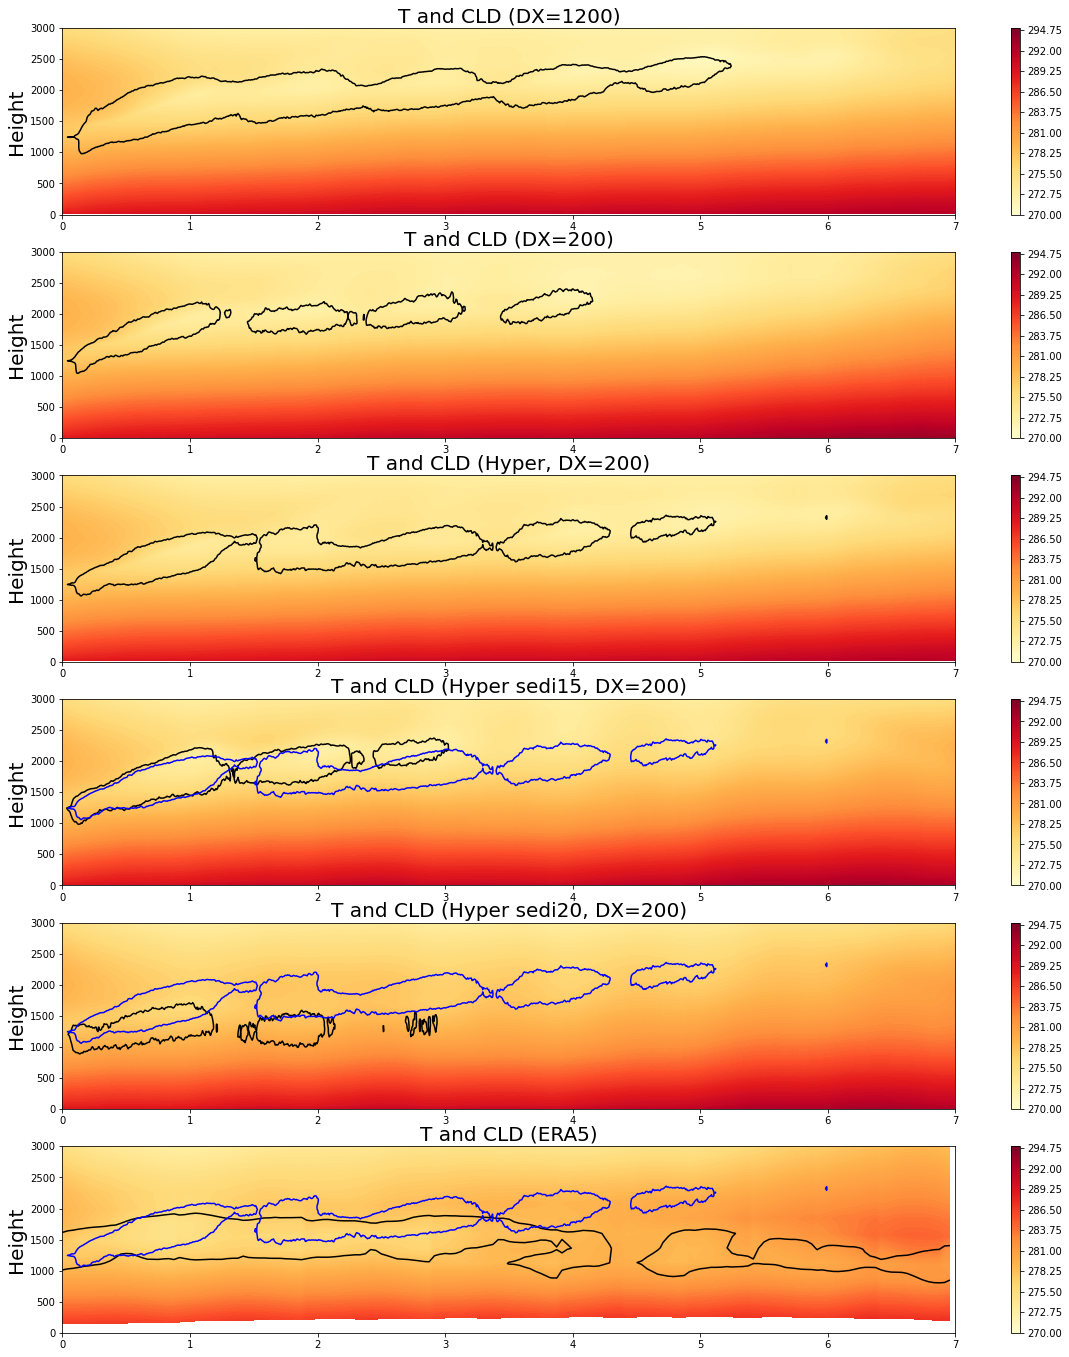

In [71]:
#  For SPCTRL and UPCTRL, both finished 5 day simulation
fig, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(nrows=6, ncols=1, figsize=(20, 24))
varmin = [270]
varmax = [295]
varinter = [101]
vardmin = [-4]
vardmax = [4]
vardinter = [101]
num1 = 1009
num2 = 1009
time0 = np.linspace(0, num1, num1)
time2 = np.linspace(0, num2, num2)
time1 = np.zeros([1009,125])
for it in range(125):
    time1[:,it] = time0
time = np.transpose(time1)
levels = np.linspace(varmin[0], varmax[0], varinter[0])
levels2 = np.linspace(vardmin[0], vardmax[0], vardinter[0])

cf = ax1.contourf(time/144,Z3_crossSPAustralian,T_crossSPAustralian,200, cmap="YlOrRd", levels=levels)
cf01 = ax1.contour(time/144,Z3_crossSPAustralian,cld_crossSPAustralian,200,colors='k', levels=[0.2], linestyles='-')
#cf0002 = ax1.contour(time/144,Z3p,cld_cross1,200, colors='k', levels=[0.8], linestyles=':')
cb = fig.colorbar(cf, ax=ax1)
ax1.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("T and CLD (DX=1200)")
tx = ax1.set_title(titlestring, fontsize=20)
#ax1.set_xlabel('Day', fontsize=20)
ax1.set_ylabel('Height', fontsize=20)

cf2 = ax2.contourf(time/144,Z3_crossUPAustralian,T_crossUPAustralian,200, cmap="YlOrRd", levels=levels)
cf02 = ax2.contour(time/144,Z3_crossUPAustralian,cld_crossUPAustralian,200,colors='k', levels=[0.2], linestyles='-')
cb2 = fig.colorbar(cf2, ax=ax2)
ax2.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("T and CLD (DX=200)")
tx = ax2.set_title(titlestring, fontsize=20)
#ax2.set_xlabel('Day', fontsize=20)
ax2.set_ylabel('Height', fontsize=20)

cf3 = ax3.contourf(time/144,Z3_crossUPhyAustralian,T_crossUPhyAustralian,200, cmap="YlOrRd", levels=levels)
cf03 = ax3.contour(time/144,Z3_crossUPhyAustralian,cld_crossUPhyAustralian,200,colors='k', levels=[0.2], linestyles='-')
cb3 = fig.colorbar(cf3, ax=ax3)
ax3.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("T and CLD (Hyper, DX=200)")
tx = ax3.set_title(titlestring, fontsize=20)
#ax2.set_xlabel('Day', fontsize=20)
ax3.set_ylabel('Height', fontsize=20)

cf4 = ax4.contourf(time/144,Z3_crossUPhysedi15Australian,T_crossUPhysedi15Australian,200, cmap="YlOrRd", levels=levels)
cf04 = ax4.contour(time/144,Z3_crossUPhysedi15Australian,cld_crossUPhysedi15Australian,200,colors='k', levels=[0.2], linestyles='-')
cf042 = ax4.contour(time/144,Z3_crossUPhyAustralian,cld_crossUPhyAustralian,200,colors='b', levels=[0.2], linestyles='-')
cb4 = fig.colorbar(cf4, ax=ax4)
ax4.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("T and CLD (Hyper sedi15, DX=200)")
tx = ax4.set_title(titlestring, fontsize=20)
#ax2.set_xlabel('Day', fontsize=20)
ax4.set_ylabel('Height', fontsize=20)

cf5 = ax5.contourf(time/144,Z3_crossUPhysedi20Australian,T_crossUPhysedi20Australian,200, cmap="YlOrRd", levels=levels)
cf05 = ax5.contour(time/144,Z3_crossUPhysedi20Australian,cld_crossUPhysedi20Australian,200,colors='k', levels=[0.2], linestyles='-')
cf052 = ax5.contour(time/144,Z3_crossUPhyAustralian,cld_crossUPhyAustralian,200,colors='b', levels=[0.2], linestyles='-')
cb5 = fig.colorbar(cf5, ax=ax5)
ax5.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("T and CLD (Hyper sedi20, DX=200)")
tx = ax5.set_title(titlestring, fontsize=20)
#ax2.set_xlabel('Day', fontsize=20)
ax5.set_ylabel('Height', fontsize=20)

cf6 = ax6.contourf(ERA_Time,ERA5_zAustralian/9.8,ERA5_tAustralian,200, cmap="YlOrRd", levels=levels)
cf06 = ax6.contour(ERA_Time,ERA5_zAustralian/9.8,ERA5_ccAustralian,200,colors='k', levels=[0.2], linestyles='-')
cf062 = ax6.contour(time/144,Z3_crossUPhyAustralian,cld_crossUPhyAustralian,200,colors='b', levels=[0.2], linestyles='-')
cb6 = fig.colorbar(cf6, ax=ax6)
ax6.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("T and CLD (ERA5)")
tx = ax6.set_title(titlestring, fontsize=20)
#ax2.set_xlabel('Day', fontsize=20)
ax6.set_ylabel('Height', fontsize=20)

plt.savefig('Australian_Time_Height_Model_ERA5.png')

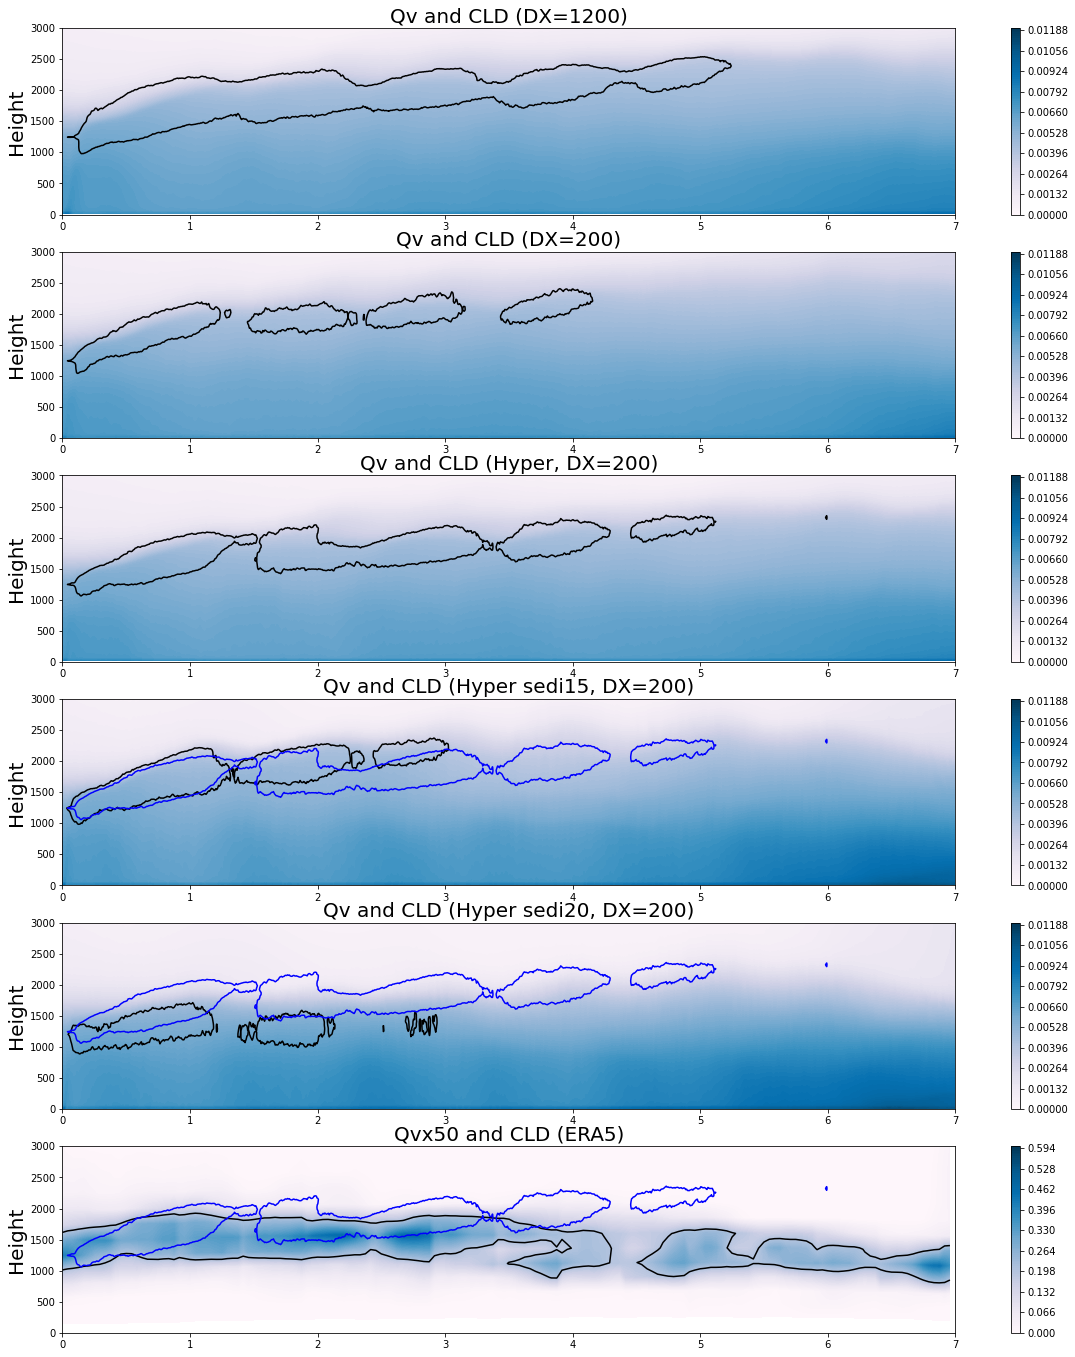

In [84]:
#  For SPCTRL and UPCTRL, both finished 5 day simulation
fig, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(nrows=6, ncols=1, figsize=(20, 24))
varmin = [0]
varmax = [0.012]
varinter = [101]
vardmin = [-4]
vardmax = [4]
vardinter = [101]
num1 = 1009
num2 = 1009
time0 = np.linspace(0, num1, num1)
time2 = np.linspace(0, num2, num2)
time1 = np.zeros([1009,125])
for it in range(125):
    time1[:,it] = time0
time = np.transpose(time1)
levels = np.linspace(varmin[0], varmax[0], varinter[0])
levels2 = np.linspace(vardmin[0], vardmax[0], vardinter[0])

cf = ax1.contourf(time/144,Z3_crossSPAustralian,Q_crossSPAustralian,200, cmap="PuBu", levels=levels)
cf01 = ax1.contour(time/144,Z3_crossSPAustralian,cld_crossSPAustralian,200,colors='k', levels=[0.2], linestyles='-')
#cf0002 = ax1.contour(time/144,Z3p,cld_cross1,200, colors='k', levels=[0.8], linestyles=':')
cb = fig.colorbar(cf, ax=ax1)
ax1.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("Qv and CLD (DX=1200)")
tx = ax1.set_title(titlestring, fontsize=20)
#ax1.seQ_xlabel('Day', fontsize=20)
ax1.set_ylabel('Height', fontsize=20)

cf2 = ax2.contourf(time/144,Z3_crossUPAustralian,Q_crossUPAustralian,200, cmap="PuBu", levels=levels)
cf02 = ax2.contour(time/144,Z3_crossUPAustralian,cld_crossUPAustralian,200,colors='k', levels=[0.2], linestyles='-')
cb2 = fig.colorbar(cf2, ax=ax2)
ax2.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("Qv and CLD (DX=200)")
tx = ax2.set_title(titlestring, fontsize=20)
#ax2.seQ_xlabel('Day', fontsize=20)
ax2.set_ylabel('Height', fontsize=20)

cf3 = ax3.contourf(time/144,Z3_crossUPhyAustralian,Q_crossUPhyAustralian,200, cmap="PuBu", levels=levels)
cf03 = ax3.contour(time/144,Z3_crossUPhyAustralian,cld_crossUPhyAustralian,200,colors='k', levels=[0.2], linestyles='-')
cb3 = fig.colorbar(cf3, ax=ax3)
ax3.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("Qv and CLD (Hyper, DX=200)")
tx = ax3.set_title(titlestring, fontsize=20)
#ax2.seQ_xlabel('Day', fontsize=20)
ax3.set_ylabel('Height', fontsize=20)

cf4 = ax4.contourf(time/144,Z3_crossUPhysedi15Australian,Q_crossUPhysedi15Australian,200, cmap="PuBu", levels=levels)
cf04 = ax4.contour(time/144,Z3_crossUPhysedi15Australian,cld_crossUPhysedi15Australian,200,colors='k', levels=[0.2], linestyles='-')
cf042 = ax4.contour(time/144,Z3_crossUPhyAustralian,cld_crossUPhyAustralian,200,colors='b', levels=[0.2], linestyles='-')
cb4 = fig.colorbar(cf4, ax=ax4)
ax4.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("Qv and CLD (Hyper sedi15, DX=200)")
tx = ax4.set_title(titlestring, fontsize=20)
#ax2.seQ_xlabel('Day', fontsize=20)
ax4.set_ylabel('Height', fontsize=20)

cf5 = ax5.contourf(time/144,Z3_crossUPhysedi20Australian,Q_crossUPhysedi20Australian,200, cmap="PuBu", levels=levels)
cf05 = ax5.contour(time/144,Z3_crossUPhysedi20Australian,cld_crossUPhysedi20Australian,200,colors='k', levels=[0.2], linestyles='-')
cf052 = ax5.contour(time/144,Z3_crossUPhyAustralian,cld_crossUPhyAustralian,200,colors='b', levels=[0.2], linestyles='-')
cb5 = fig.colorbar(cf5, ax=ax5)
ax5.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("Qv and CLD (Hyper sedi20, DX=200)")
tx = ax5.set_title(titlestring, fontsize=20)
#ax2.seQ_xlabel('Day', fontsize=20)
ax5.set_ylabel('Height', fontsize=20)

cf6 = ax6.contourf(ERA_Time,ERA5_zAustralian/9.8,ERA5_qAustralian,200, cmap="PuBu", levels=levels*50)
cf06 = ax6.contour(ERA_Time,ERA5_zAustralian/9.8,ERA5_ccAustralian,200,colors='k', levels=[0.2], linestyles='-')
cf062 = ax6.contour(time/144,Z3_crossUPhyAustralian,cld_crossUPhyAustralian,200,colors='b', levels=[0.2], linestyles='-')
cb6 = fig.colorbar(cf6, ax=ax6)
ax6.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("Qvx50 and CLD (ERA5)")
tx = ax6.set_title(titlestring, fontsize=20)
#ax2.seQ_xlabel('Day', fontsize=20)
ax6.set_ylabel('Height', fontsize=20)

plt.savefig('Australian_Time_HeighQv_Model_ERA5.png')

In [78]:
print(ERA5_qAustralian[1,:])

[0.00000000e+00 0.00000000e+00 3.60185979e-04 2.55477617e-03
 6.87333875e-03 2.19228420e-02 2.88227616e-02 7.07457880e-02
 1.37495677e-01 3.04358222e-01 3.90413959e-01 1.94559660e-01
 8.62311333e-02 1.79010238e-02 1.41249403e-05 0.00000000e+00]
